# ECE 661 Final Project: Adversarial Patch Attacks
### Jamie Liu, Hiep Nguyen, & Jack Parker

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import random_split, DataLoader
import torchvision.transforms.functional as TF
import random
import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

/home/jamie/anaconda3/envs/torch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


## Load data

In [2]:
# Normalization statistics for ImageNet data
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    normalize
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

# Load dataset
train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Split training data into training and validation sets
train_set, val_set = random_split(train_data, [40000, 10000])

# Define dataloaders
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


100%|██████████| 170498071/170498071 [00:03<00:00, 46996762.71it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Define helper functions to be used during experiments

In [3]:
# This function evaluates a model's accuracy on the validation set
# Optionally, one can pass an adversarial patch as an argument to evaluate the model's performance against a patch attack
def eval(model, patch=None, target_class=None):
  # Stats to use to calculate accuracy after the eval loop
  total_correct = 0
  total = 0
  total_target = 0
  # Put model on GPU and switch to eval mode
  model = model.to(device)
  model.eval()
  # Evaluation loop
  with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(val_loader):
      # Put data on GPU
      images = images.to(device)
      if patch is not None:
        images = apply(patch, images)
      labels = labels.to(device)
      # Make predictions
      predictions = model(images)
      predictions = torch.argmax(predictions, dim=1)
      # Update validation accuracy information
      total += len(images)
      num_correct = (predictions == labels).float().sum().item()
      total_correct += num_correct
      if target_class is not None:
        target = torch.zeros(len(images), dtype=torch.long).fill_(target_class).to(device)
        num_target = (predictions == target).float().sum().item()
        total_target += num_target
  # If evaluating the effects of a targeted patch attach, it is nice to see whether or not the model is classifying lots of examples to the target class
  if target_class is not None:
    target_percentage = total_target / total
    print(f"Percentage of samples predicted as target class {target_class}: {100 * target_percentage}")
  # Calculate accuracy
  accuracy = total_correct / total
  return accuracy

In [4]:
# This function is designed to take in a pretrained ResNet model and fine-tune its weights for the CIFAR-10 dataset
# The idea is to fine-tune ResNet for the CIFAR-10 dataset (accuracy should be around 82%) and then degrade that performance via an adversarial patch attack
def fine_tune_for_cifar10(model, num_epochs=30, model_path="resnet18.pth"):
  # Put model on GPU and put model in training mode
  model = model.to(device)
  model.train()
  # Define loss function and optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
  best_accuracy = 0.0
  best_model_path = model_path
  # Training loop
  for i in range(num_epochs):
    # Stats to use for calculating accuracy
    total_correct = 0
    total = 0
    # Iterate through each batch of data
    for batch_idx, (images, labels) in enumerate(train_loader):
      # Put data on GPU
      images = images.to(device)
      labels = labels.to(device)
      # Make predictions
      predictions = model(images)
      # Calculate loss for the batch
      loss = criterion(predictions, labels)
      # Gradient descent
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      # Update training accuracy information
      total += len(images)
      predictions = torch.argmax(predictions, dim=1)
      num_correct = (predictions == labels).float().sum().item()
      total_correct += num_correct
    # Print training accuracy
    print(f"Epoch {str(i + 1)}: Training accuracy = {str(total_correct / total)}")
    # Print validation accuracy
    val_accuracy = eval(model, patch=None, target_class=None)
    print(f"Validation accuracy: {str(val_accuracy)}")

    if val_accuracy > best_accuracy:
      best_accuracy = val_accuracy
      torch.save(model.state_dict(), best_model_path)
      print(f"Saved new best model with accuracy: {best_accuracy:.4f}")

In [5]:
# Apply patch to a batch of images
def apply(patch, batch_of_images):
  num_images = batch_of_images.shape[0]
  patch_size = patch.shape[1]
  # Iterate through each image in the batch
  for i in range(num_images):
    # Rotate the patch by a random number of degrees
    degree = random.uniform(0, 360)
    patch_rotated = TF.rotate(patch, angle=degree)
    # Randomly choose an (x, y) coordinate on the 32x32 CIFAR-10 image
    # This coordinate will be where the top left corner of the rotated patch goes
    top_left_x = random.randint(0, 31 - patch_size)
    top_left_y = random.randint(0, 31 - patch_size)
    # Apply the randomly rotated patch at the random location
    batch_of_images[i, :, top_left_x:top_left_x+patch_size, top_left_y:top_left_y+patch_size] = patch
  return batch_of_images

In [6]:
# Function to load the best model checkpoint
def load_model(model, path, device="cuda"):
    model.load_state_dict(torch.load(path, map_location=device))
    model = model.to(device)
    return model

In [7]:
# This function fine-tunes an adversarial patch against a provided whitebox model
# Model accuracy against the patch attack is reported at each step
def generate_adversarial_patch(model, patch_size, target_class=None, num_epochs=10, lr=1e-1, momentum=0.8, apply=apply):
  model = model.to(device)
  model.train()

  # Initialize patch to all zeros
  patch = nn.Parameter(torch.zeros(3, patch_size, patch_size), requires_grad=True)
  optimizer = optim.SGD([patch], lr, momentum)
  criterion = nn.CrossEntropyLoss()
  # Optimize the patch
  for i in range(num_epochs):
    print(f"Epoch {str(i + 1)}")
    for batch_idx, (images, labels) in enumerate(train_loader):
      # Put data on the GPU
      images = images.to(device)
      labels = labels.to(device)
      # Apply the patch at a random location and with a random rotation for each image in the batch
      images = apply(patch, images)
      # Make predictions on the patched images
      predictions = resnet18(images)
      # For an untargeted attack, create false labels by incrementing the true labels by 1
      if target_class is None:
        false_labels = (labels + 1) % 10
      # For a targeted attack, set all the false labels to the target class
      else:
        false_labels = torch.zeros(len(images), dtype=torch.long).fill_(target_class).to(device)
      # Tune the patch
      loss = criterion(predictions, false_labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    # See how the patch performs
    print(f"Target class: {target_class}")
    accuracy = eval(model, patch=patch, target_class=target_class)
    print(f"Accuracy: {str(accuracy)}\n")
  return patch

In [8]:
# This function test the model accuracy on clean test dataset
# Optinally, if pass in an adversarial patch, this function test model accuracy, untargetted and targetted ASR
def test(model, patch=None, target_class=None, apply=apply):
  model.eval()
  total = 0
  total_correct = 0
  total_misclassified = 0
  total_targeted_hits = 0

  with torch.no_grad():
    for images, labels in test_loader:
      images = images.to(device)
      labels = labels.to(device)

      if patch is not None:
        images = apply(patch, images)

      outputs = model(images)
      predictions = torch.argmax(outputs, dim=1)
      total += labels.size(0)
      total_correct += (predictions == labels).sum().item()
      total_misclassified += (predictions != labels).sum().item()

      if target_class is not None:
        targeted_misclassifications = ((predictions != labels) & (predictions == target_class))
        total_targeted_hits += targeted_misclassifications.sum().item()

  adversarial_accuracy = total_correct / total
  untargeted_attack_rate = total_misclassified / total

  if patch is not None:
    print(f"Model accuracy with adversarial patch: {adversarial_accuracy * 100:.2f}%")
    print(f"Untargeted attack success rate on test set: {untargeted_attack_rate * 100:.2f}%")
  else:
    print(f"Model accuracy on clean test set: {adversarial_accuracy * 100:.2f}%")

  if target_class is not None:
    targeted_attack_rate = total_targeted_hits / total
    print(f"Targeted attack success rate on test set for class {target_class}: {targeted_attack_rate * 100:.2f}%")
    return adversarial_accuracy, untargeted_attack_rate, targeted_attack_rate
  else:
    return adversarial_accuracy, untargeted_attack_rate

In [9]:
# This function takes in a patch and outputs it visually
def visualize_patch(patch):
    patch = patch.detach()
    patch = (patch - patch.min()) / (patch.max() - patch.min())  # Normalize to [0, 1]

    # Convert to numpy and transpose dimensions from [C, H, W] to [H, W, C] for visualization
    patch_np = patch.cpu().numpy().transpose(1, 2, 0)
    plt.imshow(patch_np)
    plt.axis('off')
    plt.show()


In [11]:
# This function is used to plot the (untargeted or targeted) ASR v.s. patch size
def plot_asr_vs_patch_size(patch_sizes, asr_results):
    asr_values = [asr_results[size] * 100 for size in patch_sizes]
    plt.figure(figsize=(6,4))
    plt.plot(patch_sizes, asr_values, marker='o', linestyle='-', color='b')
    plt.title('Attack Success Rate vs Patch Size')
    plt.xlabel('Patch Size (pixels)')
    plt.ylabel('ASR (%)')
    plt.grid(True)
    plt.xticks(patch_sizes)
    plt.show()


## Fine-tune ResNet18 for CIFAR-10

In [42]:
# Load pre-trained model
resnet18 = models.resnet18(weights="DEFAULT")

# ResNet is trained on ImageNet, which has 1000 classes
# So we need to modify the output layer for CIFAR-10, which has 10 classes
resnet18.fc = nn.Linear(resnet18.fc.in_features, 10)

# Finetune the model
# fine_tune_for_cifar10(model=resnet18, num_epochs=30, model_path="resnet18.pth")

# Load best model checkpoint
resnet18 = load_model(resnet18, "resnet18.pth", device=device)

# Test model performance on clean test dataset
test(model=resnet18, patch=None, target_class=None)

Model accuracy on clean test set: 82.47%


(0.8247, 0.1753)

## Experiment 1: Untargeted 8x8 patch attack on ResNet18

Epoch 1
Target class: None
Accuracy: 0.5396

Epoch 2
Target class: None
Accuracy: 0.4011

Epoch 3
Target class: None
Accuracy: 0.3665

Epoch 4
Target class: None
Accuracy: 0.3487

Epoch 5
Target class: None
Accuracy: 0.3475

Epoch 6
Target class: None
Accuracy: 0.3413

Epoch 7
Target class: None
Accuracy: 0.3351

Epoch 8
Target class: None
Accuracy: 0.327

Epoch 9
Target class: None
Accuracy: 0.3225

Epoch 10
Target class: None
Accuracy: 0.3161



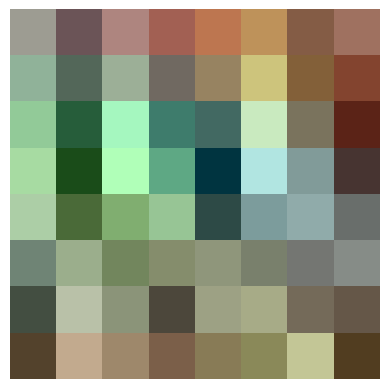

Model accuracy with adversarial patch: 35.14%
Untargeted attack success rate on test set: 64.86%


(0.3514, 0.6486)

In [13]:
# Generate adversarial patch
patch_untargeted_size8 = generate_adversarial_patch(model=resnet18, patch_size=8)

# Visualize the generated patch
visualize_patch(patch_untargeted_size8)

# Test adversarial success rate on test dataset
test(model=resnet18, patch=patch_untargeted_size8)

## Experiment 2: The effect of patch size on untargeted attack success rate for ResNet18

Epoch 1
Target class: None
Accuracy: 0.5998

Epoch 2
Target class: None
Accuracy: 0.5199

Epoch 3
Target class: None
Accuracy: 0.4506

Epoch 4
Target class: None
Accuracy: 0.4113

Epoch 5
Target class: None
Accuracy: 0.3854

Epoch 6
Target class: None
Accuracy: 0.3648

Epoch 7
Target class: None
Accuracy: 0.3564

Epoch 8
Target class: None
Accuracy: 0.3418

Epoch 9
Target class: None
Accuracy: 0.3393

Epoch 10
Target class: None
Accuracy: 0.3366



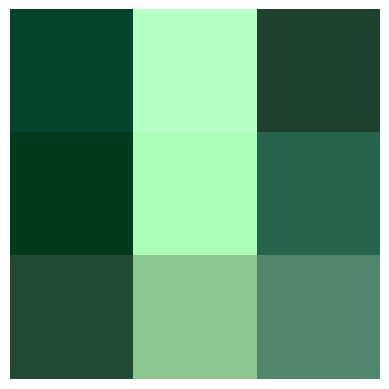

Model accuracy with adversarial patch: 35.50%
Untargeted attack success rate on test set: 64.50%
Epoch 1
Target class: None
Accuracy: 0.578

Epoch 2
Target class: None
Accuracy: 0.3828

Epoch 3
Target class: None
Accuracy: 0.2271

Epoch 4
Target class: None
Accuracy: 0.1914

Epoch 5
Target class: None
Accuracy: 0.183

Epoch 6
Target class: None
Accuracy: 0.1713

Epoch 7
Target class: None
Accuracy: 0.1714

Epoch 8
Target class: None
Accuracy: 0.1757

Epoch 9
Target class: None
Accuracy: 0.1719

Epoch 10
Target class: None
Accuracy: 0.1743



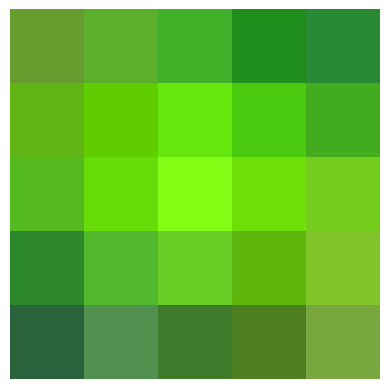

Model accuracy with adversarial patch: 18.05%
Untargeted attack success rate on test set: 81.95%
Epoch 1
Target class: None
Accuracy: 0.5716

Epoch 2
Target class: None
Accuracy: 0.4295

Epoch 3
Target class: None
Accuracy: 0.3479

Epoch 4
Target class: None
Accuracy: 0.3228

Epoch 5
Target class: None
Accuracy: 0.3138

Epoch 6
Target class: None
Accuracy: 0.3094

Epoch 7
Target class: None
Accuracy: 0.2968

Epoch 8
Target class: None
Accuracy: 0.2995

Epoch 9
Target class: None
Accuracy: 0.2958

Epoch 10
Target class: None
Accuracy: 0.2966



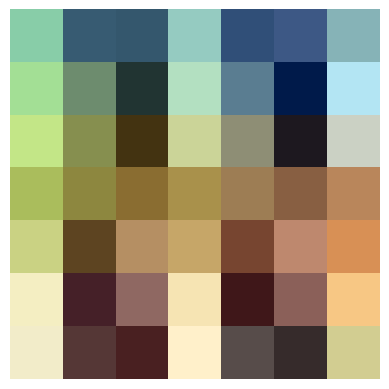

Model accuracy with adversarial patch: 30.67%
Untargeted attack success rate on test set: 69.33%
Epoch 1
Target class: None
Accuracy: 0.3401

Epoch 2
Target class: None
Accuracy: 0.1926

Epoch 3
Target class: None
Accuracy: 0.1732

Epoch 4
Target class: None
Accuracy: 0.1666

Epoch 5
Target class: None
Accuracy: 0.1616

Epoch 6
Target class: None
Accuracy: 0.1624

Epoch 7
Target class: None
Accuracy: 0.151

Epoch 8
Target class: None
Accuracy: 0.1517

Epoch 9
Target class: None
Accuracy: 0.1456

Epoch 10
Target class: None
Accuracy: 0.1405



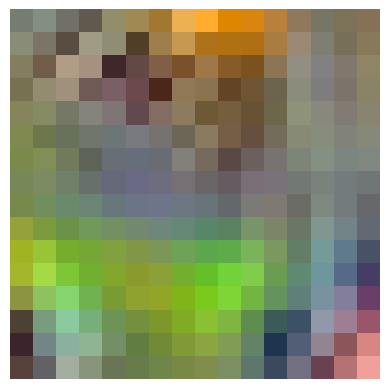

Model accuracy with adversarial patch: 14.36%
Untargeted attack success rate on test set: 85.64%


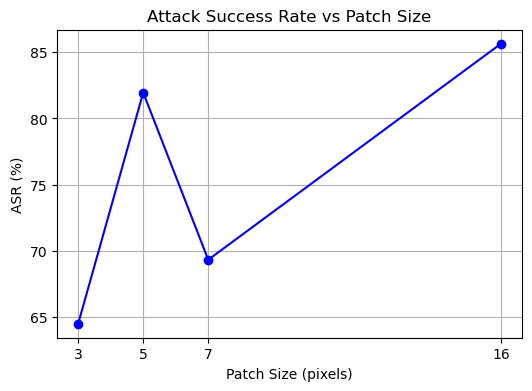

In [14]:
# Calculate untargeteded ASR for patches of various sizes and plot patch size vs. untargeted ASR
patch_sizes = [3, 5, 7, 16]
untargetted_asr_results = {}

for size in patch_sizes:
  patch = generate_adversarial_patch(model=resnet18, patch_size=size)
  visualize_patch(patch)
  adversarial_accuracy, untargetted_asr = test(model=resnet18, patch=patch)
  untargetted_asr_results[size] = untargetted_asr

plot_asr_vs_patch_size(patch_sizes, untargetted_asr_results)

## Experiment 3: Targeted patch attacks

Epoch 1
Target class: 5
Percentage of samples predicted as target class 5: 7.739999999999999
Accuracy: 0.5607

Epoch 2
Target class: 5
Percentage of samples predicted as target class 5: 69.14
Accuracy: 0.2133

Epoch 3
Target class: 5
Percentage of samples predicted as target class 5: 72.65
Accuracy: 0.1926

Epoch 4
Target class: 5
Percentage of samples predicted as target class 5: 75.02
Accuracy: 0.1851

Epoch 5
Target class: 5
Percentage of samples predicted as target class 5: 77.14999999999999
Accuracy: 0.1803

Epoch 6
Target class: 5
Percentage of samples predicted as target class 5: 78.09
Accuracy: 0.1743

Epoch 7
Target class: 5
Percentage of samples predicted as target class 5: 78.24
Accuracy: 0.1703

Epoch 8
Target class: 5
Percentage of samples predicted as target class 5: 78.25999999999999
Accuracy: 0.1743

Epoch 9
Target class: 5
Percentage of samples predicted as target class 5: 79.06
Accuracy: 0.1698

Epoch 10
Target class: 5
Percentage of samples predicted as target class 

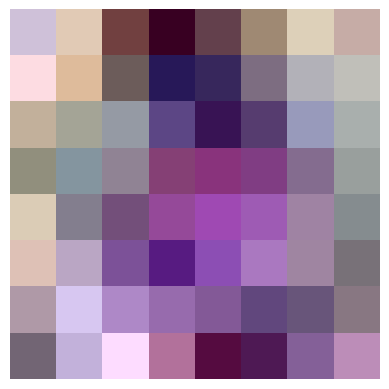

Model accuracy with adversarial patch: 19.01%
Untargeted attack success rate on test set: 80.99%
Targeted attack success rate on test set for class 5: 66.63%


(0.1901, 0.8099, 0.6663)

In [16]:
# Generate targeted adversarial patch
patch_targeted_size8 = generate_adversarial_patch(model=resnet18, patch_size=8, target_class=5)

# Visualize the generated patch
visualize_patch(patch_targeted_size8)

# Test adversarial success rate on test dataset
test(model=resnet18, patch=patch_targeted_size8, target_class=5)

In [17]:
def plot_targeted_asr_vs_patch_size(model, target_class):
  print(f"\nRUNNING EXPERIMENTS FOR TARGET CLASS {target_class}\n")
  patch_sizes = [3, 5, 7, 16]
  targetted_asr_results = {}
  for size in patch_sizes:
    patch = generate_adversarial_patch(model=model, patch_size=size, target_class=target_class)
    visualize_patch(patch)
    adversarial_accuracy, untargetted_asr, targetted_asr = test(model=resnet18, patch=patch, target_class=target_class)
    targetted_asr_results[size] = targetted_asr
  plot_asr_vs_patch_size(patch_sizes, targetted_asr_results)


RUNNING EXPERIMENTS FOR TARGET CLASS 0

Epoch 1
Target class: 0
Percentage of samples predicted as target class 0: 6.550000000000001
Accuracy: 0.6166

Epoch 2
Target class: 0
Percentage of samples predicted as target class 0: 27.700000000000003
Accuracy: 0.2809

Epoch 3
Target class: 0
Percentage of samples predicted as target class 0: 34.07
Accuracy: 0.2335

Epoch 4
Target class: 0
Percentage of samples predicted as target class 0: 37.81
Accuracy: 0.2117

Epoch 5
Target class: 0
Percentage of samples predicted as target class 0: 37.63
Accuracy: 0.1999

Epoch 6
Target class: 0
Percentage of samples predicted as target class 0: 37.480000000000004
Accuracy: 0.1906

Epoch 7
Target class: 0
Percentage of samples predicted as target class 0: 36.68
Accuracy: 0.1907

Epoch 8
Target class: 0
Percentage of samples predicted as target class 0: 36.89
Accuracy: 0.1814

Epoch 9
Target class: 0
Percentage of samples predicted as target class 0: 36.55
Accuracy: 0.1885

Epoch 10
Target class: 0
Perce

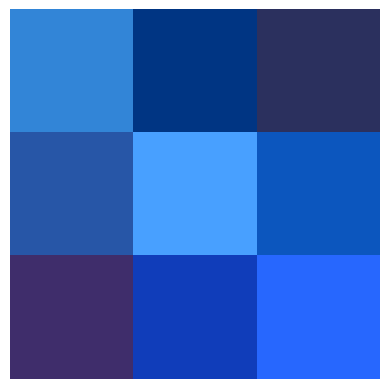

Model accuracy with adversarial patch: 18.69%
Untargeted attack success rate on test set: 81.31%
Targeted attack success rate on test set for class 0: 30.75%
Epoch 1
Target class: 0
Percentage of samples predicted as target class 0: 5.76
Accuracy: 0.5816

Epoch 2
Target class: 0
Percentage of samples predicted as target class 0: 36.95
Accuracy: 0.2345

Epoch 3
Target class: 0
Percentage of samples predicted as target class 0: 43.2
Accuracy: 0.1976

Epoch 4
Target class: 0
Percentage of samples predicted as target class 0: 44.0
Accuracy: 0.1848

Epoch 5
Target class: 0
Percentage of samples predicted as target class 0: 44.9
Accuracy: 0.1755

Epoch 6
Target class: 0
Percentage of samples predicted as target class 0: 45.7
Accuracy: 0.17

Epoch 7
Target class: 0
Percentage of samples predicted as target class 0: 45.76
Accuracy: 0.1633

Epoch 8
Target class: 0
Percentage of samples predicted as target class 0: 46.35
Accuracy: 0.1686

Epoch 9
Target class: 0
Percentage of samples predicted a

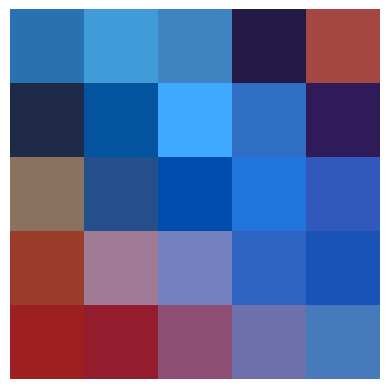

Model accuracy with adversarial patch: 16.49%
Untargeted attack success rate on test set: 83.51%
Targeted attack success rate on test set for class 0: 40.08%
Epoch 1
Target class: 0
Percentage of samples predicted as target class 0: 4.8500000000000005
Accuracy: 0.5624

Epoch 2
Target class: 0
Percentage of samples predicted as target class 0: 48.59
Accuracy: 0.2293

Epoch 3
Target class: 0
Percentage of samples predicted as target class 0: 56.39999999999999
Accuracy: 0.1888

Epoch 4
Target class: 0
Percentage of samples predicted as target class 0: 55.96
Accuracy: 0.1703

Epoch 5
Target class: 0
Percentage of samples predicted as target class 0: 55.96
Accuracy: 0.1688

Epoch 6
Target class: 0
Percentage of samples predicted as target class 0: 56.830000000000005
Accuracy: 0.1644

Epoch 7
Target class: 0
Percentage of samples predicted as target class 0: 55.75
Accuracy: 0.1633

Epoch 8
Target class: 0
Percentage of samples predicted as target class 0: 56.84
Accuracy: 0.1609

Epoch 9
Targ

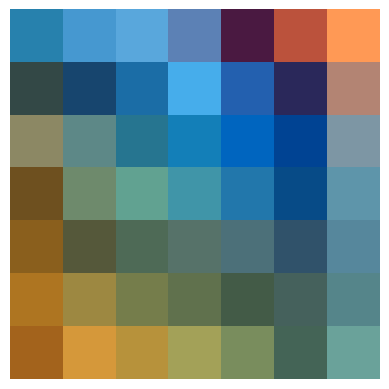

Model accuracy with adversarial patch: 16.46%
Untargeted attack success rate on test set: 83.54%
Targeted attack success rate on test set for class 0: 48.93%
Epoch 1
Target class: 0
Percentage of samples predicted as target class 0: 5.83
Accuracy: 0.3599

Epoch 2
Target class: 0
Percentage of samples predicted as target class 0: 96.39999999999999
Accuracy: 0.113

Epoch 3
Target class: 0
Percentage of samples predicted as target class 0: 97.87
Accuracy: 0.109

Epoch 4
Target class: 0
Percentage of samples predicted as target class 0: 98.47
Accuracy: 0.1065

Epoch 5
Target class: 0
Percentage of samples predicted as target class 0: 99.07000000000001
Accuracy: 0.105

Epoch 6
Target class: 0
Percentage of samples predicted as target class 0: 99.09
Accuracy: 0.1042

Epoch 7
Target class: 0
Percentage of samples predicted as target class 0: 99.15
Accuracy: 0.1036

Epoch 8
Target class: 0
Percentage of samples predicted as target class 0: 99.19
Accuracy: 0.1045

Epoch 9
Target class: 0
Percen

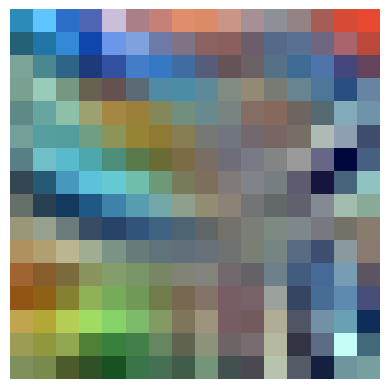

Model accuracy with adversarial patch: 10.26%
Untargeted attack success rate on test set: 89.74%
Targeted attack success rate on test set for class 0: 89.19%


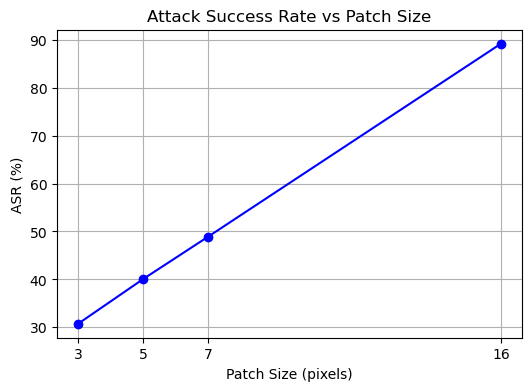


RUNNING EXPERIMENTS FOR TARGET CLASS 1

Epoch 1
Target class: 1
Percentage of samples predicted as target class 1: 6.329999999999999
Accuracy: 0.6194

Epoch 2
Target class: 1
Percentage of samples predicted as target class 1: 13.56
Accuracy: 0.454

Epoch 3
Target class: 1
Percentage of samples predicted as target class 1: 59.870000000000005
Accuracy: 0.2229

Epoch 4
Target class: 1
Percentage of samples predicted as target class 1: 72.13000000000001
Accuracy: 0.1763

Epoch 5
Target class: 1
Percentage of samples predicted as target class 1: 75.33
Accuracy: 0.1705

Epoch 6
Target class: 1
Percentage of samples predicted as target class 1: 76.98
Accuracy: 0.1648

Epoch 7
Target class: 1
Percentage of samples predicted as target class 1: 78.05
Accuracy: 0.1568

Epoch 8
Target class: 1
Percentage of samples predicted as target class 1: 77.38000000000001
Accuracy: 0.1589

Epoch 9
Target class: 1
Percentage of samples predicted as target class 1: 78.32000000000001
Accuracy: 0.1593

Epoch 10

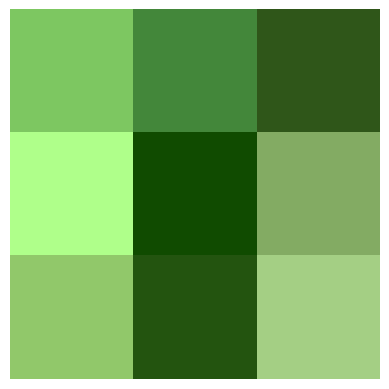

Model accuracy with adversarial patch: 16.36%
Untargeted attack success rate on test set: 83.64%
Targeted attack success rate on test set for class 1: 65.06%
Epoch 1
Target class: 1
Percentage of samples predicted as target class 1: 6.819999999999999
Accuracy: 0.5929

Epoch 2
Target class: 1
Percentage of samples predicted as target class 1: 60.25
Accuracy: 0.2155

Epoch 3
Target class: 1
Percentage of samples predicted as target class 1: 81.64
Accuracy: 0.1506

Epoch 4
Target class: 1
Percentage of samples predicted as target class 1: 84.72
Accuracy: 0.1418

Epoch 5
Target class: 1
Percentage of samples predicted as target class 1: 86.02
Accuracy: 0.1401

Epoch 6
Target class: 1
Percentage of samples predicted as target class 1: 87.7
Accuracy: 0.1363

Epoch 7
Target class: 1
Percentage of samples predicted as target class 1: 88.27000000000001
Accuracy: 0.132

Epoch 8
Target class: 1
Percentage of samples predicted as target class 1: 88.5
Accuracy: 0.1298

Epoch 9
Target class: 1
Perce

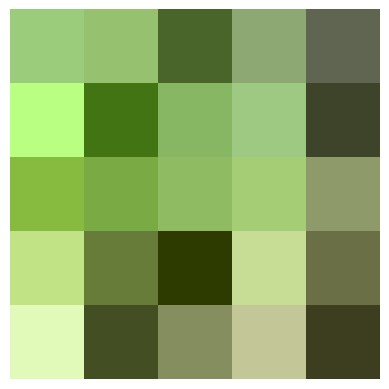

Model accuracy with adversarial patch: 13.65%
Untargeted attack success rate on test set: 86.35%
Targeted attack success rate on test set for class 1: 76.15%
Epoch 1
Target class: 1
Percentage of samples predicted as target class 1: 5.53
Accuracy: 0.5667

Epoch 2
Target class: 1
Percentage of samples predicted as target class 1: 67.36999999999999
Accuracy: 0.1707

Epoch 3
Target class: 1
Percentage of samples predicted as target class 1: 83.03
Accuracy: 0.1369

Epoch 4
Target class: 1
Percentage of samples predicted as target class 1: 87.22
Accuracy: 0.13

Epoch 5
Target class: 1
Percentage of samples predicted as target class 1: 89.59
Accuracy: 0.1261

Epoch 6
Target class: 1
Percentage of samples predicted as target class 1: 90.25999999999999
Accuracy: 0.1246

Epoch 7
Target class: 1
Percentage of samples predicted as target class 1: 91.67999999999999
Accuracy: 0.1225

Epoch 8
Target class: 1
Percentage of samples predicted as target class 1: 91.86
Accuracy: 0.1204

Epoch 9
Target cl

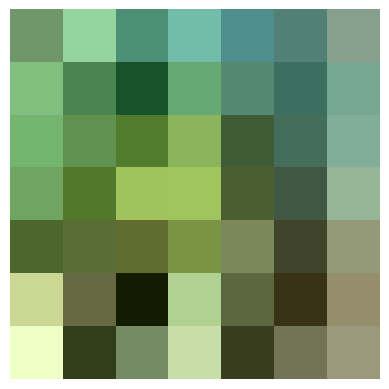

Model accuracy with adversarial patch: 12.53%
Untargeted attack success rate on test set: 87.47%
Targeted attack success rate on test set for class 1: 80.75%
Epoch 1
Target class: 1
Percentage of samples predicted as target class 1: 3.2399999999999998
Accuracy: 0.3549

Epoch 2
Target class: 1
Percentage of samples predicted as target class 1: 96.35000000000001
Accuracy: 0.1128

Epoch 3
Target class: 1
Percentage of samples predicted as target class 1: 98.79
Accuracy: 0.1066

Epoch 4
Target class: 1
Percentage of samples predicted as target class 1: 99.36
Accuracy: 0.1051

Epoch 5
Target class: 1
Percentage of samples predicted as target class 1: 99.52
Accuracy: 0.1048

Epoch 6
Target class: 1
Percentage of samples predicted as target class 1: 99.56
Accuracy: 0.104

Epoch 7
Target class: 1
Percentage of samples predicted as target class 1: 99.63
Accuracy: 0.1041

Epoch 8
Target class: 1
Percentage of samples predicted as target class 1: 99.74
Accuracy: 0.1033

Epoch 9
Target class: 1
Pe

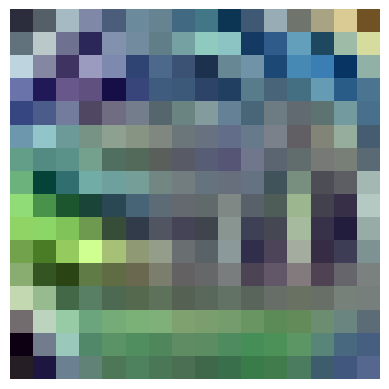

Model accuracy with adversarial patch: 10.17%
Untargeted attack success rate on test set: 89.83%
Targeted attack success rate on test set for class 1: 89.51%


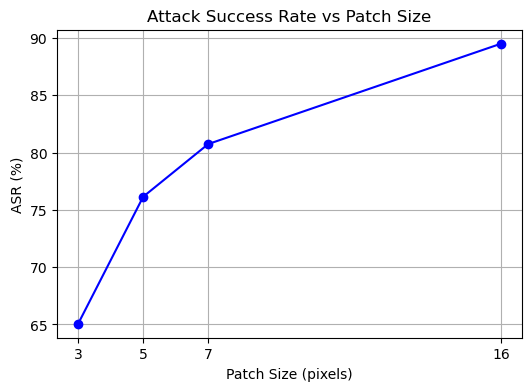


RUNNING EXPERIMENTS FOR TARGET CLASS 2

Epoch 1
Target class: 2
Percentage of samples predicted as target class 2: 8.85
Accuracy: 0.6218

Epoch 2
Target class: 2
Percentage of samples predicted as target class 2: 49.15
Accuracy: 0.3357

Epoch 3
Target class: 2
Percentage of samples predicted as target class 2: 58.919999999999995
Accuracy: 0.2727

Epoch 4
Target class: 2
Percentage of samples predicted as target class 2: 61.24000000000001
Accuracy: 0.2516

Epoch 5
Target class: 2
Percentage of samples predicted as target class 2: 62.5
Accuracy: 0.2369

Epoch 6
Target class: 2
Percentage of samples predicted as target class 2: 63.39
Accuracy: 0.2329

Epoch 7
Target class: 2
Percentage of samples predicted as target class 2: 64.22
Accuracy: 0.2299

Epoch 8
Target class: 2
Percentage of samples predicted as target class 2: 64.42
Accuracy: 0.2243

Epoch 9
Target class: 2
Percentage of samples predicted as target class 2: 64.14
Accuracy: 0.2264

Epoch 10
Target class: 2
Percentage of sample

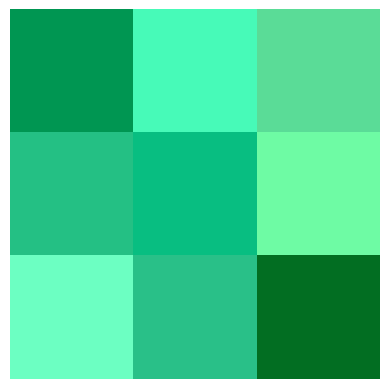

Model accuracy with adversarial patch: 23.70%
Untargeted attack success rate on test set: 76.30%
Targeted attack success rate on test set for class 2: 52.83%
Epoch 1
Target class: 2
Percentage of samples predicted as target class 2: 8.37
Accuracy: 0.608

Epoch 2
Target class: 2
Percentage of samples predicted as target class 2: 59.95
Accuracy: 0.2618

Epoch 3
Target class: 2
Percentage of samples predicted as target class 2: 68.44
Accuracy: 0.2248

Epoch 4
Target class: 2
Percentage of samples predicted as target class 2: 71.6
Accuracy: 0.2092

Epoch 5
Target class: 2
Percentage of samples predicted as target class 2: 72.89
Accuracy: 0.2054

Epoch 6
Target class: 2
Percentage of samples predicted as target class 2: 73.75
Accuracy: 0.1995

Epoch 7
Target class: 2
Percentage of samples predicted as target class 2: 74.26
Accuracy: 0.1959

Epoch 8
Target class: 2
Percentage of samples predicted as target class 2: 74.36
Accuracy: 0.195

Epoch 9
Target class: 2
Percentage of samples predicte

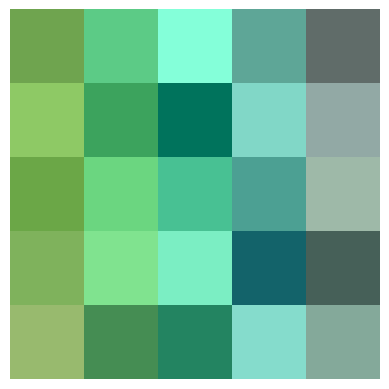

Model accuracy with adversarial patch: 20.02%
Untargeted attack success rate on test set: 79.98%
Targeted attack success rate on test set for class 2: 64.51%
Epoch 1
Target class: 2
Percentage of samples predicted as target class 2: 8.9
Accuracy: 0.5698

Epoch 2
Target class: 2
Percentage of samples predicted as target class 2: 65.23
Accuracy: 0.2331

Epoch 3
Target class: 2
Percentage of samples predicted as target class 2: 71.21
Accuracy: 0.2074

Epoch 4
Target class: 2
Percentage of samples predicted as target class 2: 74.83999999999999
Accuracy: 0.19

Epoch 5
Target class: 2
Percentage of samples predicted as target class 2: 76.77000000000001
Accuracy: 0.1808

Epoch 6
Target class: 2
Percentage of samples predicted as target class 2: 78.42
Accuracy: 0.1787

Epoch 7
Target class: 2
Percentage of samples predicted as target class 2: 79.51
Accuracy: 0.1732

Epoch 8
Target class: 2
Percentage of samples predicted as target class 2: 80.17
Accuracy: 0.1754

Epoch 9
Target class: 2
Percen

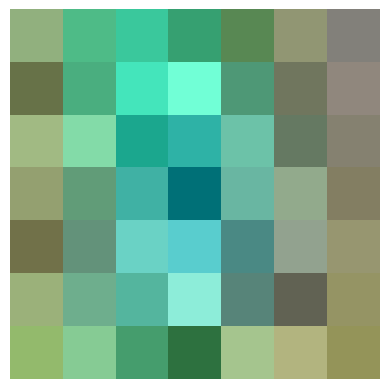

Model accuracy with adversarial patch: 17.13%
Untargeted attack success rate on test set: 82.87%
Targeted attack success rate on test set for class 2: 71.27%
Epoch 1
Target class: 2
Percentage of samples predicted as target class 2: 11.24
Accuracy: 0.381

Epoch 2
Target class: 2
Percentage of samples predicted as target class 2: 96.65
Accuracy: 0.112

Epoch 3
Target class: 2
Percentage of samples predicted as target class 2: 98.3
Accuracy: 0.1074

Epoch 4
Target class: 2
Percentage of samples predicted as target class 2: 98.95
Accuracy: 0.1042

Epoch 5
Target class: 2
Percentage of samples predicted as target class 2: 99.19
Accuracy: 0.103

Epoch 6
Target class: 2
Percentage of samples predicted as target class 2: 99.36
Accuracy: 0.1022

Epoch 7
Target class: 2
Percentage of samples predicted as target class 2: 99.53999999999999
Accuracy: 0.1019

Epoch 8
Target class: 2
Percentage of samples predicted as target class 2: 99.41
Accuracy: 0.1023

Epoch 9
Target class: 2
Percentage of samp

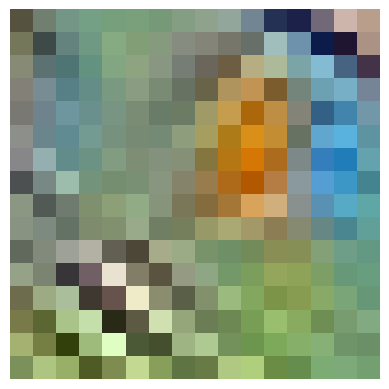

Model accuracy with adversarial patch: 10.19%
Untargeted attack success rate on test set: 89.81%
Targeted attack success rate on test set for class 2: 89.36%


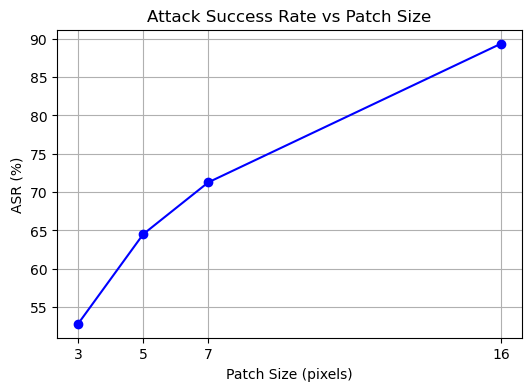


RUNNING EXPERIMENTS FOR TARGET CLASS 3

Epoch 1
Target class: 3
Percentage of samples predicted as target class 3: 27.51
Accuracy: 0.5962

Epoch 2
Target class: 3
Percentage of samples predicted as target class 3: 46.31
Accuracy: 0.3379

Epoch 3
Target class: 3
Percentage of samples predicted as target class 3: 48.93
Accuracy: 0.2996

Epoch 4
Target class: 3
Percentage of samples predicted as target class 3: 47.620000000000005
Accuracy: 0.2871

Epoch 5
Target class: 3
Percentage of samples predicted as target class 3: 48.44
Accuracy: 0.2875

Epoch 6
Target class: 3
Percentage of samples predicted as target class 3: 48.17
Accuracy: 0.2844

Epoch 7
Target class: 3
Percentage of samples predicted as target class 3: 47.620000000000005
Accuracy: 0.2814

Epoch 8
Target class: 3
Percentage of samples predicted as target class 3: 47.510000000000005
Accuracy: 0.2802

Epoch 9
Target class: 3
Percentage of samples predicted as target class 3: 48.949999999999996
Accuracy: 0.2772

Epoch 10
Target 

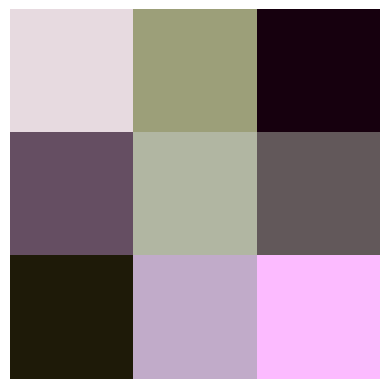

Model accuracy with adversarial patch: 28.95%
Untargeted attack success rate on test set: 71.05%
Targeted attack success rate on test set for class 3: 38.89%
Epoch 1
Target class: 3
Percentage of samples predicted as target class 3: 25.040000000000003
Accuracy: 0.5913

Epoch 2
Target class: 3
Percentage of samples predicted as target class 3: 55.1
Accuracy: 0.2863

Epoch 3
Target class: 3
Percentage of samples predicted as target class 3: 55.64
Accuracy: 0.2725

Epoch 4
Target class: 3
Percentage of samples predicted as target class 3: 58.089999999999996
Accuracy: 0.2589

Epoch 5
Target class: 3
Percentage of samples predicted as target class 3: 55.92
Accuracy: 0.2611

Epoch 6
Target class: 3
Percentage of samples predicted as target class 3: 56.42
Accuracy: 0.2488

Epoch 7
Target class: 3
Percentage of samples predicted as target class 3: 55.769999999999996
Accuracy: 0.2526

Epoch 8
Target class: 3
Percentage of samples predicted as target class 3: 56.31
Accuracy: 0.2502

Epoch 9
Targ

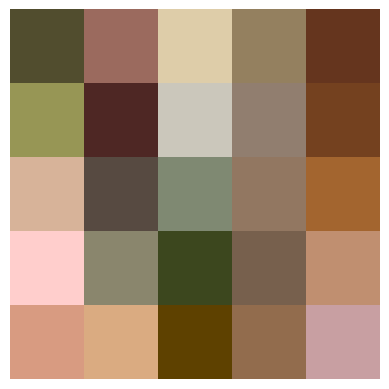

Model accuracy with adversarial patch: 27.17%
Untargeted attack success rate on test set: 72.83%
Targeted attack success rate on test set for class 3: 45.53%
Epoch 1
Target class: 3
Percentage of samples predicted as target class 3: 23.78
Accuracy: 0.5885

Epoch 2
Target class: 3
Percentage of samples predicted as target class 3: 66.86
Accuracy: 0.2508

Epoch 3
Target class: 3
Percentage of samples predicted as target class 3: 69.78
Accuracy: 0.2279

Epoch 4
Target class: 3
Percentage of samples predicted as target class 3: 71.5
Accuracy: 0.2155

Epoch 5
Target class: 3
Percentage of samples predicted as target class 3: 73.26
Accuracy: 0.2113

Epoch 6
Target class: 3
Percentage of samples predicted as target class 3: 73.58
Accuracy: 0.2064

Epoch 7
Target class: 3
Percentage of samples predicted as target class 3: 74.36
Accuracy: 0.2082

Epoch 8
Target class: 3
Percentage of samples predicted as target class 3: 74.74
Accuracy: 0.1997

Epoch 9
Target class: 3
Percentage of samples predi

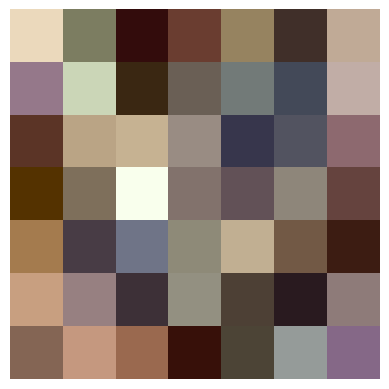

Model accuracy with adversarial patch: 21.50%
Untargeted attack success rate on test set: 78.50%
Targeted attack success rate on test set for class 3: 63.28%
Epoch 1
Target class: 3
Percentage of samples predicted as target class 3: 26.83
Accuracy: 0.4061

Epoch 2
Target class: 3
Percentage of samples predicted as target class 3: 94.38
Accuracy: 0.1188

Epoch 3
Target class: 3
Percentage of samples predicted as target class 3: 97.04
Accuracy: 0.1092

Epoch 4
Target class: 3
Percentage of samples predicted as target class 3: 97.52
Accuracy: 0.1097

Epoch 5
Target class: 3
Percentage of samples predicted as target class 3: 98.33
Accuracy: 0.1057

Epoch 6
Target class: 3
Percentage of samples predicted as target class 3: 98.54
Accuracy: 0.1038

Epoch 7
Target class: 3
Percentage of samples predicted as target class 3: 98.68
Accuracy: 0.1046

Epoch 8
Target class: 3
Percentage of samples predicted as target class 3: 98.76
Accuracy: 0.1038

Epoch 9
Target class: 3
Percentage of samples pred

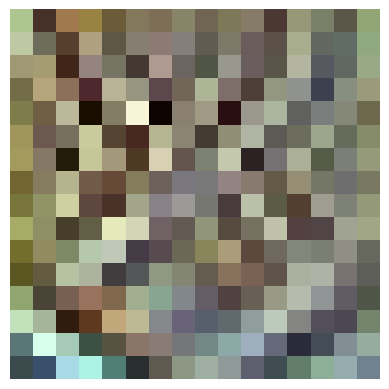

Model accuracy with adversarial patch: 10.61%
Untargeted attack success rate on test set: 89.39%
Targeted attack success rate on test set for class 3: 88.42%


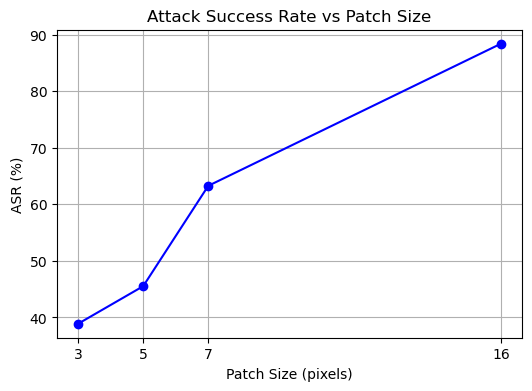


RUNNING EXPERIMENTS FOR TARGET CLASS 4

Epoch 1
Target class: 4
Percentage of samples predicted as target class 4: 11.52
Accuracy: 0.6196

Epoch 2
Target class: 4
Percentage of samples predicted as target class 4: 15.079999999999998
Accuracy: 0.5954

Epoch 3
Target class: 4
Percentage of samples predicted as target class 4: 14.790000000000001
Accuracy: 0.5866

Epoch 4
Target class: 4
Percentage of samples predicted as target class 4: 14.860000000000001
Accuracy: 0.5837

Epoch 5
Target class: 4
Percentage of samples predicted as target class 4: 15.32
Accuracy: 0.5834

Epoch 6
Target class: 4
Percentage of samples predicted as target class 4: 14.860000000000001
Accuracy: 0.5819

Epoch 7
Target class: 4
Percentage of samples predicted as target class 4: 14.860000000000001
Accuracy: 0.5734

Epoch 8
Target class: 4
Percentage of samples predicted as target class 4: 14.860000000000001
Accuracy: 0.5843

Epoch 9
Target class: 4
Percentage of samples predicted as target class 4: 15.19000000000

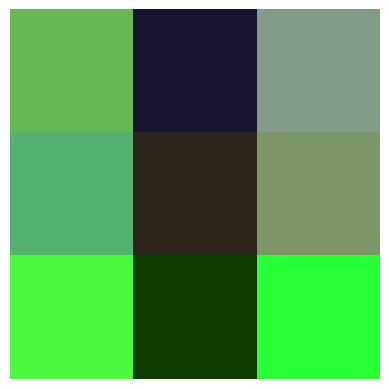

Model accuracy with adversarial patch: 56.64%
Untargeted attack success rate on test set: 43.36%
Targeted attack success rate on test set for class 4: 12.06%
Epoch 1
Target class: 4
Percentage of samples predicted as target class 4: 12.61
Accuracy: 0.5945

Epoch 2
Target class: 4
Percentage of samples predicted as target class 4: 20.79
Accuracy: 0.5372

Epoch 3
Target class: 4
Percentage of samples predicted as target class 4: 22.17
Accuracy: 0.5116

Epoch 4
Target class: 4
Percentage of samples predicted as target class 4: 22.38
Accuracy: 0.4981

Epoch 5
Target class: 4
Percentage of samples predicted as target class 4: 23.03
Accuracy: 0.4963

Epoch 6
Target class: 4
Percentage of samples predicted as target class 4: 23.150000000000002
Accuracy: 0.4913

Epoch 7
Target class: 4
Percentage of samples predicted as target class 4: 23.44
Accuracy: 0.483

Epoch 8
Target class: 4
Percentage of samples predicted as target class 4: 23.66
Accuracy: 0.4792

Epoch 9
Target class: 4
Percentage of 

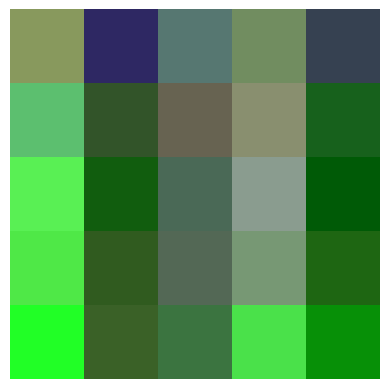

Model accuracy with adversarial patch: 48.50%
Untargeted attack success rate on test set: 51.50%
Targeted attack success rate on test set for class 4: 20.84%
Epoch 1
Target class: 4
Percentage of samples predicted as target class 4: 11.379999999999999
Accuracy: 0.5808

Epoch 2
Target class: 4
Percentage of samples predicted as target class 4: 23.84
Accuracy: 0.4906

Epoch 3
Target class: 4
Percentage of samples predicted as target class 4: 25.69
Accuracy: 0.457

Epoch 4
Target class: 4
Percentage of samples predicted as target class 4: 26.71
Accuracy: 0.4348

Epoch 5
Target class: 4
Percentage of samples predicted as target class 4: 26.529999999999998
Accuracy: 0.44

Epoch 6
Target class: 4
Percentage of samples predicted as target class 4: 26.640000000000004
Accuracy: 0.4261

Epoch 7
Target class: 4
Percentage of samples predicted as target class 4: 26.97
Accuracy: 0.418

Epoch 8
Target class: 4
Percentage of samples predicted as target class 4: 27.1
Accuracy: 0.4175

Epoch 9
Target c

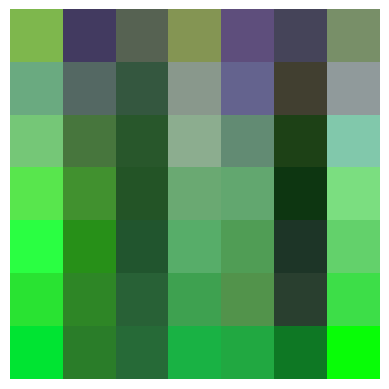

Model accuracy with adversarial patch: 43.45%
Untargeted attack success rate on test set: 56.55%
Targeted attack success rate on test set for class 4: 24.57%
Epoch 1
Target class: 4
Percentage of samples predicted as target class 4: 12.370000000000001
Accuracy: 0.3692

Epoch 2
Target class: 4
Percentage of samples predicted as target class 4: 88.16000000000001
Accuracy: 0.1518

Epoch 3
Target class: 4
Percentage of samples predicted as target class 4: 93.21000000000001
Accuracy: 0.1277

Epoch 4
Target class: 4
Percentage of samples predicted as target class 4: 95.0
Accuracy: 0.1204

Epoch 5
Target class: 4
Percentage of samples predicted as target class 4: 96.3
Accuracy: 0.1158

Epoch 6
Target class: 4
Percentage of samples predicted as target class 4: 96.91
Accuracy: 0.114

Epoch 7
Target class: 4
Percentage of samples predicted as target class 4: 97.44
Accuracy: 0.1107

Epoch 8
Target class: 4
Percentage of samples predicted as target class 4: 97.55
Accuracy: 0.109

Epoch 9
Target cl

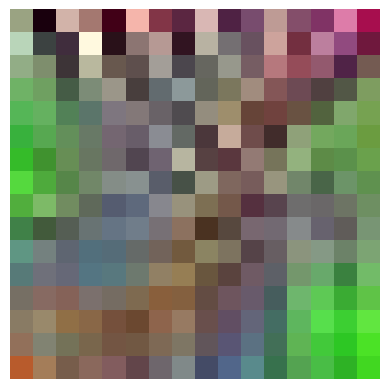

Model accuracy with adversarial patch: 10.75%
Untargeted attack success rate on test set: 89.25%
Targeted attack success rate on test set for class 4: 87.89%


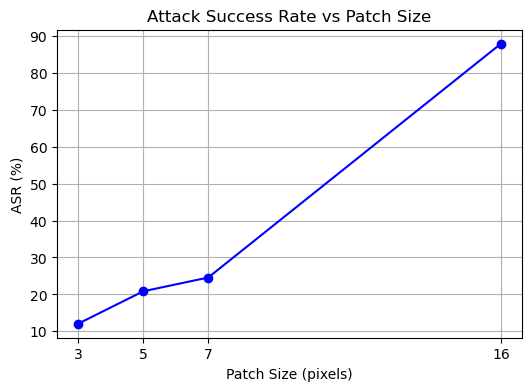


RUNNING EXPERIMENTS FOR TARGET CLASS 5

Epoch 1
Target class: 5
Percentage of samples predicted as target class 5: 9.09
Accuracy: 0.6182

Epoch 2
Target class: 5
Percentage of samples predicted as target class 5: 25.540000000000003
Accuracy: 0.4259

Epoch 3
Target class: 5
Percentage of samples predicted as target class 5: 30.94
Accuracy: 0.3588

Epoch 4
Target class: 5
Percentage of samples predicted as target class 5: 33.58
Accuracy: 0.3215

Epoch 5
Target class: 5
Percentage of samples predicted as target class 5: 34.660000000000004
Accuracy: 0.3057

Epoch 6
Target class: 5
Percentage of samples predicted as target class 5: 35.85
Accuracy: 0.2898

Epoch 7
Target class: 5
Percentage of samples predicted as target class 5: 35.480000000000004
Accuracy: 0.295

Epoch 8
Target class: 5
Percentage of samples predicted as target class 5: 35.94
Accuracy: 0.2818

Epoch 9
Target class: 5
Percentage of samples predicted as target class 5: 36.1
Accuracy: 0.2873

Epoch 10
Target class: 5
Percent

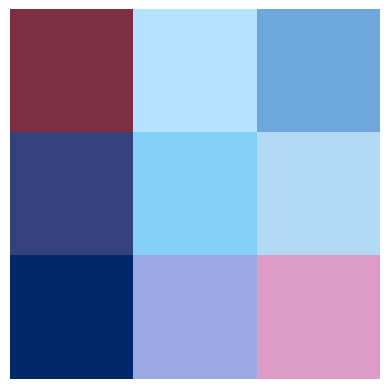

Model accuracy with adversarial patch: 30.03%
Untargeted attack success rate on test set: 69.97%
Targeted attack success rate on test set for class 5: 25.81%
Epoch 1
Target class: 5
Percentage of samples predicted as target class 5: 8.55
Accuracy: 0.5894

Epoch 2
Target class: 5
Percentage of samples predicted as target class 5: 49.35
Accuracy: 0.2759

Epoch 3
Target class: 5
Percentage of samples predicted as target class 5: 55.779999999999994
Accuracy: 0.2466

Epoch 4
Target class: 5
Percentage of samples predicted as target class 5: 57.16
Accuracy: 0.2342

Epoch 5
Target class: 5
Percentage of samples predicted as target class 5: 58.040000000000006
Accuracy: 0.2228

Epoch 6
Target class: 5
Percentage of samples predicted as target class 5: 57.67
Accuracy: 0.218

Epoch 7
Target class: 5
Percentage of samples predicted as target class 5: 58.220000000000006
Accuracy: 0.2185

Epoch 8
Target class: 5
Percentage of samples predicted as target class 5: 58.43000000000001
Accuracy: 0.2211

E

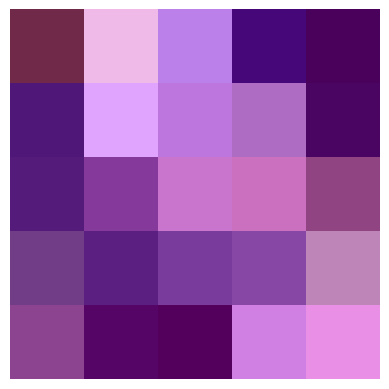

Model accuracy with adversarial patch: 24.18%
Untargeted attack success rate on test set: 75.82%
Targeted attack success rate on test set for class 5: 47.20%
Epoch 1
Target class: 5
Percentage of samples predicted as target class 5: 8.86
Accuracy: 0.5891

Epoch 2
Target class: 5
Percentage of samples predicted as target class 5: 63.470000000000006
Accuracy: 0.2443

Epoch 3
Target class: 5
Percentage of samples predicted as target class 5: 68.97999999999999
Accuracy: 0.2124

Epoch 4
Target class: 5
Percentage of samples predicted as target class 5: 71.88
Accuracy: 0.1919

Epoch 5
Target class: 5
Percentage of samples predicted as target class 5: 72.07000000000001
Accuracy: 0.1923

Epoch 6
Target class: 5
Percentage of samples predicted as target class 5: 74.03
Accuracy: 0.1887

Epoch 7
Target class: 5
Percentage of samples predicted as target class 5: 73.97
Accuracy: 0.1852

Epoch 8
Target class: 5
Percentage of samples predicted as target class 5: 75.22999999999999
Accuracy: 0.1803

Ep

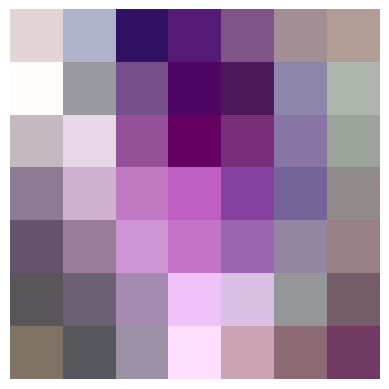

Model accuracy with adversarial patch: 20.18%
Untargeted attack success rate on test set: 79.82%
Targeted attack success rate on test set for class 5: 63.21%
Epoch 1
Target class: 5
Percentage of samples predicted as target class 5: 8.5
Accuracy: 0.3977

Epoch 2
Target class: 5
Percentage of samples predicted as target class 5: 96.7
Accuracy: 0.1094

Epoch 3
Target class: 5
Percentage of samples predicted as target class 5: 97.88
Accuracy: 0.1027

Epoch 4
Target class: 5
Percentage of samples predicted as target class 5: 98.39
Accuracy: 0.1008

Epoch 5
Target class: 5
Percentage of samples predicted as target class 5: 98.59
Accuracy: 0.1013

Epoch 6
Target class: 5
Percentage of samples predicted as target class 5: 98.67
Accuracy: 0.1

Epoch 7
Target class: 5
Percentage of samples predicted as target class 5: 99.00999999999999
Accuracy: 0.1004

Epoch 8
Target class: 5
Percentage of samples predicted as target class 5: 98.89
Accuracy: 0.0997

Epoch 9
Target class: 5
Percentage of sample

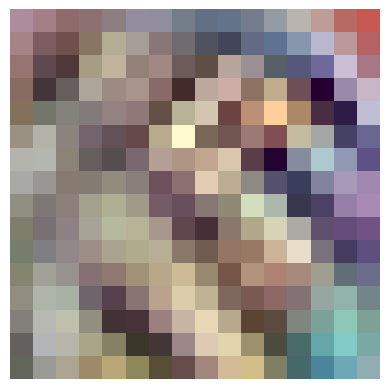

Model accuracy with adversarial patch: 10.56%
Untargeted attack success rate on test set: 89.44%
Targeted attack success rate on test set for class 5: 88.60%


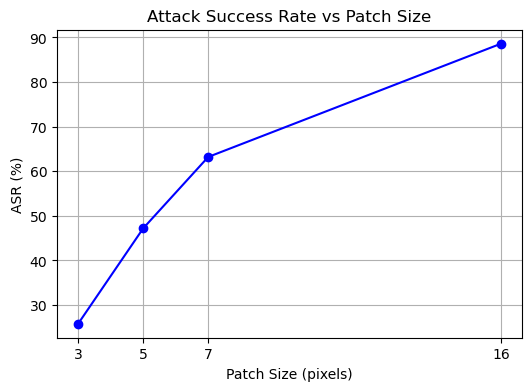


RUNNING EXPERIMENTS FOR TARGET CLASS 6

Epoch 1
Target class: 6
Percentage of samples predicted as target class 6: 9.959999999999999
Accuracy: 0.6331

Epoch 2
Target class: 6
Percentage of samples predicted as target class 6: 36.64
Accuracy: 0.3016

Epoch 3
Target class: 6
Percentage of samples predicted as target class 6: 35.56
Accuracy: 0.2583

Epoch 4
Target class: 6
Percentage of samples predicted as target class 6: 34.88
Accuracy: 0.2536

Epoch 5
Target class: 6
Percentage of samples predicted as target class 6: 35.14
Accuracy: 0.247

Epoch 6
Target class: 6
Percentage of samples predicted as target class 6: 33.900000000000006
Accuracy: 0.2537

Epoch 7
Target class: 6
Percentage of samples predicted as target class 6: 35.3
Accuracy: 0.2487

Epoch 8
Target class: 6
Percentage of samples predicted as target class 6: 35.199999999999996
Accuracy: 0.2491

Epoch 9
Target class: 6
Percentage of samples predicted as target class 6: 35.31
Accuracy: 0.2442

Epoch 10
Target class: 6
Percent

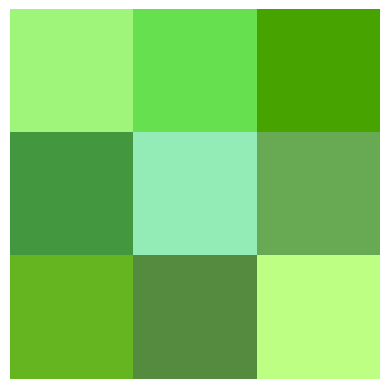

Model accuracy with adversarial patch: 25.25%
Untargeted attack success rate on test set: 74.75%
Targeted attack success rate on test set for class 6: 30.49%
Epoch 1
Target class: 6
Percentage of samples predicted as target class 6: 9.9
Accuracy: 0.593

Epoch 2
Target class: 6
Percentage of samples predicted as target class 6: 45.190000000000005
Accuracy: 0.25

Epoch 3
Target class: 6
Percentage of samples predicted as target class 6: 45.540000000000006
Accuracy: 0.2321

Epoch 4
Target class: 6
Percentage of samples predicted as target class 6: 44.74
Accuracy: 0.2303

Epoch 5
Target class: 6
Percentage of samples predicted as target class 6: 46.32
Accuracy: 0.2303

Epoch 6
Target class: 6
Percentage of samples predicted as target class 6: 46.02
Accuracy: 0.2287

Epoch 7
Target class: 6
Percentage of samples predicted as target class 6: 46.71
Accuracy: 0.2279

Epoch 8
Target class: 6
Percentage of samples predicted as target class 6: 46.68
Accuracy: 0.2253

Epoch 9
Target class: 6
Perce

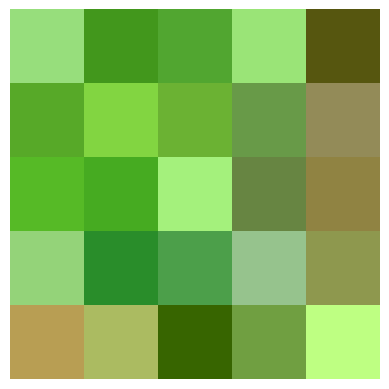

Model accuracy with adversarial patch: 22.69%
Untargeted attack success rate on test set: 77.31%
Targeted attack success rate on test set for class 6: 40.90%
Epoch 1
Target class: 6
Percentage of samples predicted as target class 6: 9.1
Accuracy: 0.5599

Epoch 2
Target class: 6
Percentage of samples predicted as target class 6: 57.24
Accuracy: 0.2136

Epoch 3
Target class: 6
Percentage of samples predicted as target class 6: 58.87
Accuracy: 0.209

Epoch 4
Target class: 6
Percentage of samples predicted as target class 6: 59.81999999999999
Accuracy: 0.204

Epoch 5
Target class: 6
Percentage of samples predicted as target class 6: 61.28
Accuracy: 0.194

Epoch 6
Target class: 6
Percentage of samples predicted as target class 6: 61.4
Accuracy: 0.1952

Epoch 7
Target class: 6
Percentage of samples predicted as target class 6: 62.08
Accuracy: 0.1992

Epoch 8
Target class: 6
Percentage of samples predicted as target class 6: 62.43
Accuracy: 0.1997

Epoch 9
Target class: 6
Percentage of sample

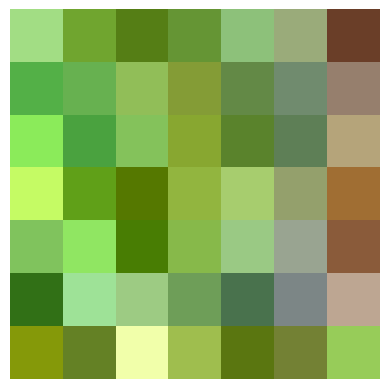

Model accuracy with adversarial patch: 19.43%
Untargeted attack success rate on test set: 80.57%
Targeted attack success rate on test set for class 6: 56.65%
Epoch 1
Target class: 6
Percentage of samples predicted as target class 6: 10.979999999999999
Accuracy: 0.3638

Epoch 2
Target class: 6
Percentage of samples predicted as target class 6: 96.08
Accuracy: 0.1117

Epoch 3
Target class: 6
Percentage of samples predicted as target class 6: 96.66
Accuracy: 0.1116

Epoch 4
Target class: 6
Percentage of samples predicted as target class 6: 97.32
Accuracy: 0.109

Epoch 5
Target class: 6
Percentage of samples predicted as target class 6: 97.58
Accuracy: 0.108

Epoch 6
Target class: 6
Percentage of samples predicted as target class 6: 98.06
Accuracy: 0.1064

Epoch 7
Target class: 6
Percentage of samples predicted as target class 6: 98.22999999999999
Accuracy: 0.1063

Epoch 8
Target class: 6
Percentage of samples predicted as target class 6: 98.39
Accuracy: 0.1071

Epoch 9
Target class: 6
Per

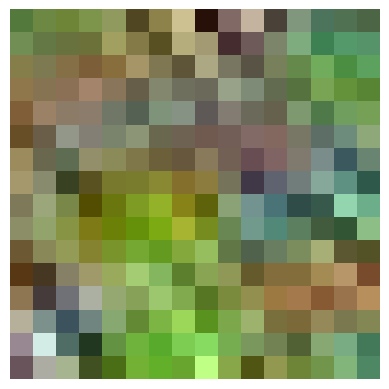

Model accuracy with adversarial patch: 10.44%
Untargeted attack success rate on test set: 89.56%
Targeted attack success rate on test set for class 6: 88.74%


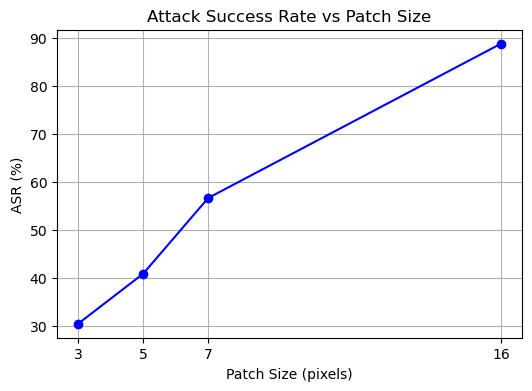


RUNNING EXPERIMENTS FOR TARGET CLASS 7

Epoch 1
Target class: 7
Percentage of samples predicted as target class 7: 6.01
Accuracy: 0.5993

Epoch 2
Target class: 7
Percentage of samples predicted as target class 7: 7.01
Accuracy: 0.5112

Epoch 3
Target class: 7
Percentage of samples predicted as target class 7: 6.29
Accuracy: 0.4601

Epoch 4
Target class: 7
Percentage of samples predicted as target class 7: 6.01
Accuracy: 0.4459

Epoch 5
Target class: 7
Percentage of samples predicted as target class 7: 6.32
Accuracy: 0.4429

Epoch 6
Target class: 7
Percentage of samples predicted as target class 7: 6.1
Accuracy: 0.4306

Epoch 7
Target class: 7
Percentage of samples predicted as target class 7: 6.260000000000001
Accuracy: 0.4354

Epoch 8
Target class: 7
Percentage of samples predicted as target class 7: 6.23
Accuracy: 0.4331

Epoch 9
Target class: 7
Percentage of samples predicted as target class 7: 6.370000000000001
Accuracy: 0.4326

Epoch 10
Target class: 7
Percentage of samples predi

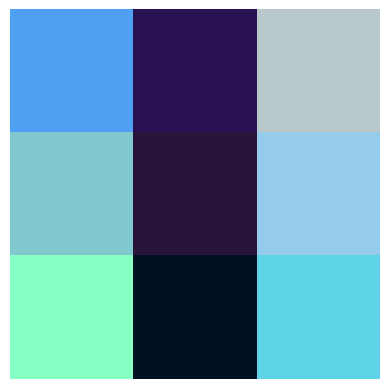

Model accuracy with adversarial patch: 45.52%
Untargeted attack success rate on test set: 54.48%
Targeted attack success rate on test set for class 7: 1.52%
Epoch 1
Target class: 7
Percentage of samples predicted as target class 7: 5.7299999999999995
Accuracy: 0.5987

Epoch 2
Target class: 7
Percentage of samples predicted as target class 7: 7.8
Accuracy: 0.4568

Epoch 3
Target class: 7
Percentage of samples predicted as target class 7: 8.33
Accuracy: 0.4296

Epoch 4
Target class: 7
Percentage of samples predicted as target class 7: 9.58
Accuracy: 0.4196

Epoch 5
Target class: 7
Percentage of samples predicted as target class 7: 10.34
Accuracy: 0.4186

Epoch 6
Target class: 7
Percentage of samples predicted as target class 7: 10.73
Accuracy: 0.4094

Epoch 7
Target class: 7
Percentage of samples predicted as target class 7: 11.1
Accuracy: 0.4003

Epoch 8
Target class: 7
Percentage of samples predicted as target class 7: 11.379999999999999
Accuracy: 0.3914

Epoch 9
Target class: 7
Percen

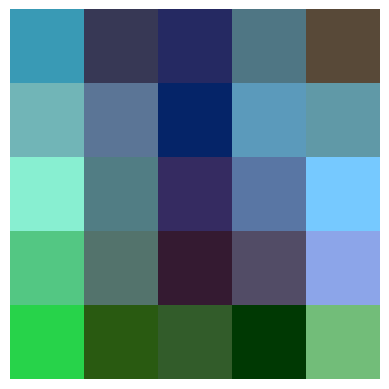

Model accuracy with adversarial patch: 41.03%
Untargeted attack success rate on test set: 58.97%
Targeted attack success rate on test set for class 7: 4.90%
Epoch 1
Target class: 7
Percentage of samples predicted as target class 7: 5.34
Accuracy: 0.5521

Epoch 2
Target class: 7
Percentage of samples predicted as target class 7: 14.31
Accuracy: 0.4292

Epoch 3
Target class: 7
Percentage of samples predicted as target class 7: 16.97
Accuracy: 0.3909

Epoch 4
Target class: 7
Percentage of samples predicted as target class 7: 18.240000000000002
Accuracy: 0.3697

Epoch 5
Target class: 7
Percentage of samples predicted as target class 7: 19.439999999999998
Accuracy: 0.3581

Epoch 6
Target class: 7
Percentage of samples predicted as target class 7: 19.75
Accuracy: 0.3525

Epoch 7
Target class: 7
Percentage of samples predicted as target class 7: 20.21
Accuracy: 0.348

Epoch 8
Target class: 7
Percentage of samples predicted as target class 7: 19.88
Accuracy: 0.3435

Epoch 9
Target class: 7
Per

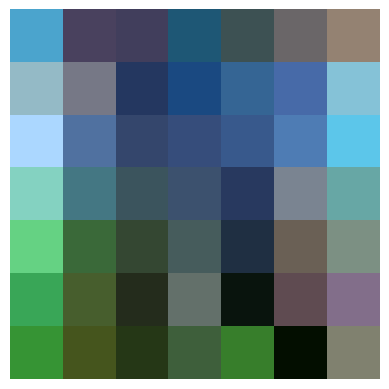

Model accuracy with adversarial patch: 36.19%
Untargeted attack success rate on test set: 63.81%
Targeted attack success rate on test set for class 7: 11.60%
Epoch 1
Target class: 7
Percentage of samples predicted as target class 7: 4.25
Accuracy: 0.3853

Epoch 2
Target class: 7
Percentage of samples predicted as target class 7: 92.96
Accuracy: 0.1284

Epoch 3
Target class: 7
Percentage of samples predicted as target class 7: 95.78
Accuracy: 0.1166

Epoch 4
Target class: 7
Percentage of samples predicted as target class 7: 97.00999999999999
Accuracy: 0.1125

Epoch 5
Target class: 7
Percentage of samples predicted as target class 7: 97.56
Accuracy: 0.1112

Epoch 6
Target class: 7
Percentage of samples predicted as target class 7: 97.72
Accuracy: 0.1112

Epoch 7
Target class: 7
Percentage of samples predicted as target class 7: 97.92999999999999
Accuracy: 0.11

Epoch 8
Target class: 7
Percentage of samples predicted as target class 7: 98.38
Accuracy: 0.1097

Epoch 9
Target class: 7
Perce

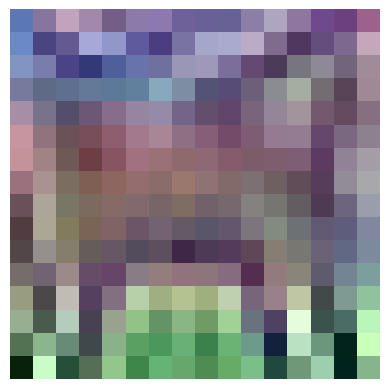

Model accuracy with adversarial patch: 10.75%
Untargeted attack success rate on test set: 89.25%
Targeted attack success rate on test set for class 7: 87.91%


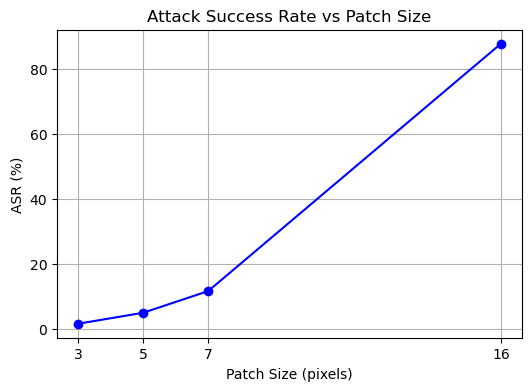


RUNNING EXPERIMENTS FOR TARGET CLASS 8

Epoch 1
Target class: 8
Percentage of samples predicted as target class 8: 8.780000000000001
Accuracy: 0.609

Epoch 2
Target class: 8
Percentage of samples predicted as target class 8: 8.95
Accuracy: 0.5913

Epoch 3
Target class: 8
Percentage of samples predicted as target class 8: 7.489999999999999
Accuracy: 0.5362

Epoch 4
Target class: 8
Percentage of samples predicted as target class 8: 6.77
Accuracy: 0.4925

Epoch 5
Target class: 8
Percentage of samples predicted as target class 8: 6.47
Accuracy: 0.4674

Epoch 6
Target class: 8
Percentage of samples predicted as target class 8: 7.4399999999999995
Accuracy: 0.4461

Epoch 7
Target class: 8
Percentage of samples predicted as target class 8: 6.54
Accuracy: 0.4109

Epoch 8
Target class: 8
Percentage of samples predicted as target class 8: 5.949999999999999
Accuracy: 0.3605

Epoch 9
Target class: 8
Percentage of samples predicted as target class 8: 7.55
Accuracy: 0.2732

Epoch 10
Target class: 8


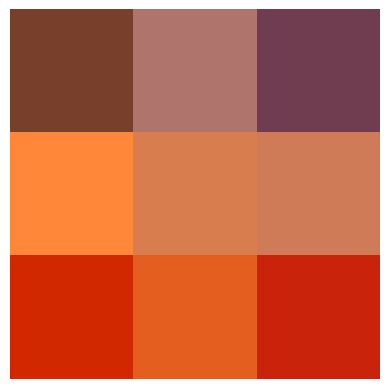

Model accuracy with adversarial patch: 21.64%
Untargeted attack success rate on test set: 78.36%
Targeted attack success rate on test set for class 8: 17.14%
Epoch 1
Target class: 8
Percentage of samples predicted as target class 8: 8.110000000000001
Accuracy: 0.5891

Epoch 2
Target class: 8
Percentage of samples predicted as target class 8: 15.079999999999998
Accuracy: 0.4267

Epoch 3
Target class: 8
Percentage of samples predicted as target class 8: 20.45
Accuracy: 0.3589

Epoch 4
Target class: 8
Percentage of samples predicted as target class 8: 21.740000000000002
Accuracy: 0.305

Epoch 5
Target class: 8
Percentage of samples predicted as target class 8: 22.48
Accuracy: 0.2786

Epoch 6
Target class: 8
Percentage of samples predicted as target class 8: 23.830000000000002
Accuracy: 0.2604

Epoch 7
Target class: 8
Percentage of samples predicted as target class 8: 25.19
Accuracy: 0.2389

Epoch 8
Target class: 8
Percentage of samples predicted as target class 8: 25.91
Accuracy: 0.2406



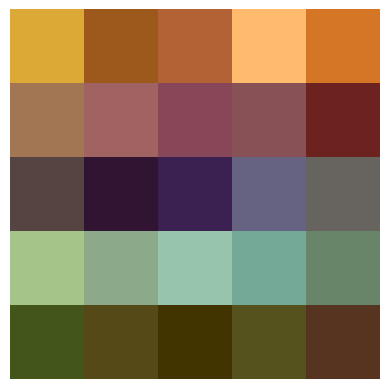

Model accuracy with adversarial patch: 22.49%
Untargeted attack success rate on test set: 77.51%
Targeted attack success rate on test set for class 8: 19.85%
Epoch 1
Target class: 8
Percentage of samples predicted as target class 8: 7.88
Accuracy: 0.538

Epoch 2
Target class: 8
Percentage of samples predicted as target class 8: 37.18
Accuracy: 0.3258

Epoch 3
Target class: 8
Percentage of samples predicted as target class 8: 48.980000000000004
Accuracy: 0.2695

Epoch 4
Target class: 8
Percentage of samples predicted as target class 8: 52.54
Accuracy: 0.242

Epoch 5
Target class: 8
Percentage of samples predicted as target class 8: 54.76
Accuracy: 0.2257

Epoch 6
Target class: 8
Percentage of samples predicted as target class 8: 56.74
Accuracy: 0.2153

Epoch 7
Target class: 8
Percentage of samples predicted as target class 8: 58.28
Accuracy: 0.2153

Epoch 8
Target class: 8
Percentage of samples predicted as target class 8: 58.650000000000006
Accuracy: 0.2

Epoch 9
Target class: 8
Percen

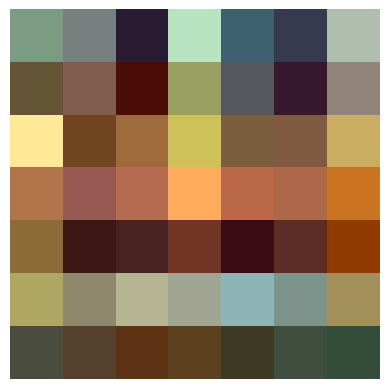

Model accuracy with adversarial patch: 21.94%
Untargeted attack success rate on test set: 78.06%
Targeted attack success rate on test set for class 8: 48.50%
Epoch 1
Target class: 8
Percentage of samples predicted as target class 8: 6.5600000000000005
Accuracy: 0.3459

Epoch 2
Target class: 8
Percentage of samples predicted as target class 8: 87.63
Accuracy: 0.127

Epoch 3
Target class: 8
Percentage of samples predicted as target class 8: 92.47
Accuracy: 0.1118

Epoch 4
Target class: 8
Percentage of samples predicted as target class 8: 94.39
Accuracy: 0.1083

Epoch 5
Target class: 8
Percentage of samples predicted as target class 8: 95.06
Accuracy: 0.1084

Epoch 6
Target class: 8
Percentage of samples predicted as target class 8: 96.24000000000001
Accuracy: 0.1051

Epoch 7
Target class: 8
Percentage of samples predicted as target class 8: 96.74000000000001
Accuracy: 0.1037

Epoch 8
Target class: 8
Percentage of samples predicted as target class 8: 97.24000000000001
Accuracy: 0.1026

Ep

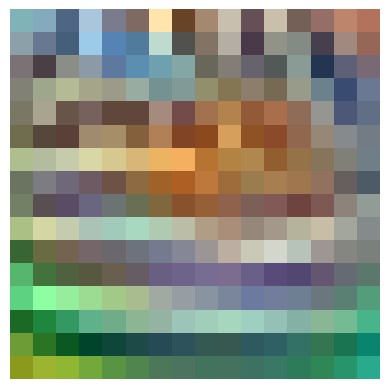

Model accuracy with adversarial patch: 10.51%
Untargeted attack success rate on test set: 89.49%
Targeted attack success rate on test set for class 8: 86.86%


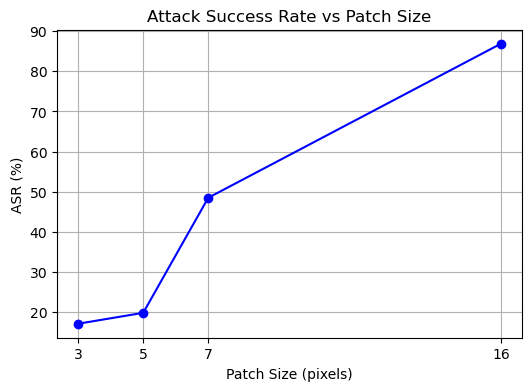


RUNNING EXPERIMENTS FOR TARGET CLASS 9

Epoch 1
Target class: 9
Percentage of samples predicted as target class 9: 9.790000000000001
Accuracy: 0.5982

Epoch 2
Target class: 9
Percentage of samples predicted as target class 9: 17.740000000000002
Accuracy: 0.4182

Epoch 3
Target class: 9
Percentage of samples predicted as target class 9: 16.96
Accuracy: 0.357

Epoch 4
Target class: 9
Percentage of samples predicted as target class 9: 16.93
Accuracy: 0.3302

Epoch 5
Target class: 9
Percentage of samples predicted as target class 9: 16.939999999999998
Accuracy: 0.3072

Epoch 6
Target class: 9
Percentage of samples predicted as target class 9: 17.95
Accuracy: 0.2858

Epoch 7
Target class: 9
Percentage of samples predicted as target class 9: 17.71
Accuracy: 0.2598

Epoch 8
Target class: 9
Percentage of samples predicted as target class 9: 16.7
Accuracy: 0.238

Epoch 9
Target class: 9
Percentage of samples predicted as target class 9: 16.28
Accuracy: 0.2353

Epoch 10
Target class: 9
Percenta

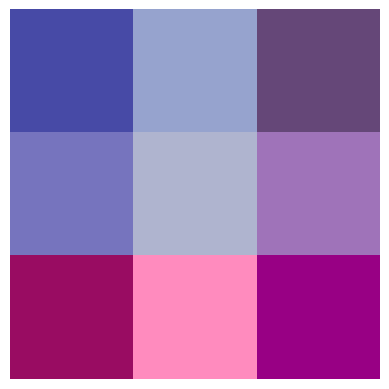

Model accuracy with adversarial patch: 24.88%
Untargeted attack success rate on test set: 75.12%
Targeted attack success rate on test set for class 9: 10.46%
Epoch 1
Target class: 9
Percentage of samples predicted as target class 9: 8.690000000000001
Accuracy: 0.5908

Epoch 2
Target class: 9
Percentage of samples predicted as target class 9: 33.83
Accuracy: 0.3333

Epoch 3
Target class: 9
Percentage of samples predicted as target class 9: 38.629999999999995
Accuracy: 0.2489

Epoch 4
Target class: 9
Percentage of samples predicted as target class 9: 38.07
Accuracy: 0.2314

Epoch 5
Target class: 9
Percentage of samples predicted as target class 9: 37.35
Accuracy: 0.2192

Epoch 6
Target class: 9
Percentage of samples predicted as target class 9: 37.03
Accuracy: 0.207

Epoch 7
Target class: 9
Percentage of samples predicted as target class 9: 36.88
Accuracy: 0.1986

Epoch 8
Target class: 9
Percentage of samples predicted as target class 9: 36.44
Accuracy: 0.2037

Epoch 9
Target class: 9
Pe

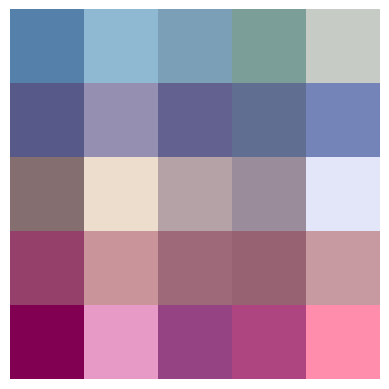

Model accuracy with adversarial patch: 21.09%
Untargeted attack success rate on test set: 78.91%
Targeted attack success rate on test set for class 9: 28.08%
Epoch 1
Target class: 9
Percentage of samples predicted as target class 9: 10.11
Accuracy: 0.5717

Epoch 2
Target class: 9
Percentage of samples predicted as target class 9: 66.81
Accuracy: 0.2423

Epoch 3
Target class: 9
Percentage of samples predicted as target class 9: 76.0
Accuracy: 0.1945

Epoch 4
Target class: 9
Percentage of samples predicted as target class 9: 81.15
Accuracy: 0.1707

Epoch 5
Target class: 9
Percentage of samples predicted as target class 9: 83.27
Accuracy: 0.1577

Epoch 6
Target class: 9
Percentage of samples predicted as target class 9: 84.59
Accuracy: 0.1507

Epoch 7
Target class: 9
Percentage of samples predicted as target class 9: 85.83
Accuracy: 0.1476

Epoch 8
Target class: 9
Percentage of samples predicted as target class 9: 86.33
Accuracy: 0.1448

Epoch 9
Target class: 9
Percentage of samples predi

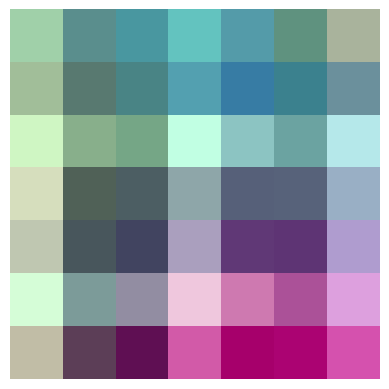

Model accuracy with adversarial patch: 15.39%
Untargeted attack success rate on test set: 84.61%
Targeted attack success rate on test set for class 9: 75.06%
Epoch 1
Target class: 9
Percentage of samples predicted as target class 9: 9.89
Accuracy: 0.3628

Epoch 2
Target class: 9
Percentage of samples predicted as target class 9: 98.41
Accuracy: 0.1073

Epoch 3
Target class: 9
Percentage of samples predicted as target class 9: 99.19
Accuracy: 0.1041

Epoch 4
Target class: 9
Percentage of samples predicted as target class 9: 99.48
Accuracy: 0.1031

Epoch 5
Target class: 9
Percentage of samples predicted as target class 9: 99.49
Accuracy: 0.1033

Epoch 6
Target class: 9
Percentage of samples predicted as target class 9: 99.53999999999999
Accuracy: 0.1019

Epoch 7
Target class: 9
Percentage of samples predicted as target class 9: 99.69
Accuracy: 0.1019

Epoch 8
Target class: 9
Percentage of samples predicted as target class 9: 99.7
Accuracy: 0.1017

Epoch 9
Target class: 9
Percentage of sa

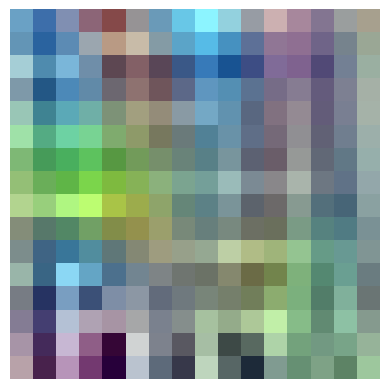

Model accuracy with adversarial patch: 10.44%
Untargeted attack success rate on test set: 89.56%
Targeted attack success rate on test set for class 9: 89.27%


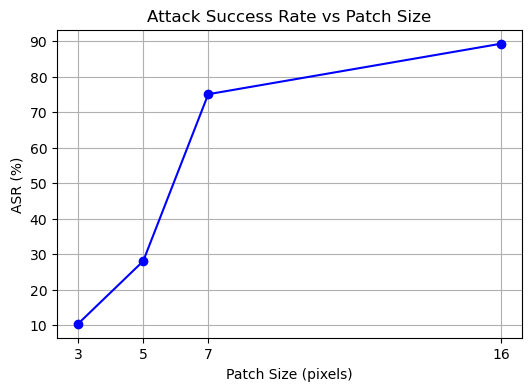

In [18]:
for target_class in range(10):
  plot_targeted_asr_vs_patch_size(resnet18, target_class)

## Experiment 4: Transferring patches to other models

In [21]:
# Load pre-trained model
resnet50 = models.resnet50(weights="DEFAULT")

# ResNet is trained on ImageNet, which has 1000 classes
# So we need to modify the output layer for CIFAR-10, which has 10 classes
resnet50.fc = nn.Linear(resnet50.fc.in_features, 10)

# Finetune the model
fine_tune_for_cifar10(model=resnet50, num_epochs=30, model_path="resnet50.pth")

# Load best model checkpoint
resnet50 = load_model(resnet50, "resnet50.pth", device=device)

# Test model performance on clean test dataset
test(model=resnet50, patch=None, target_class=None)

print("\n------------------------------------------------------------------------------------\nTESTING PATCH TRANSFER FROM RESNET18 TO RESNET50")

# Untargeted Attack
test(model=resnet50, patch=patch_untargeted_size8, target_class=None)

# Targeted Attack
test(model=resnet50, patch=patch_targeted_size8, target_class=5)

Epoch 1: Training accuracy = 0.510425
Validation accuracy: 0.6711
Saved new best model with accuracy: 0.6711
Epoch 2: Training accuracy = 0.529675
Validation accuracy: 0.7079
Saved new best model with accuracy: 0.7079
Epoch 3: Training accuracy = 0.687575
Validation accuracy: 0.6877
Epoch 4: Training accuracy = 0.737075
Validation accuracy: 0.7099
Saved new best model with accuracy: 0.7099
Epoch 5: Training accuracy = 0.765425
Validation accuracy: 0.7542
Saved new best model with accuracy: 0.7542
Epoch 6: Training accuracy = 0.78125
Validation accuracy: 0.7604
Saved new best model with accuracy: 0.7604
Epoch 7: Training accuracy = 0.79515
Validation accuracy: 0.7685
Saved new best model with accuracy: 0.7685
Epoch 8: Training accuracy = 0.807
Validation accuracy: 0.7741
Saved new best model with accuracy: 0.7741
Epoch 9: Training accuracy = 0.8189
Validation accuracy: 0.7839
Saved new best model with accuracy: 0.7839
Epoch 10: Training accuracy = 0.826925
Validation accuracy: 0.8056
Sa

(0.4562, 0.5438, 0.2918)

### Test untarget & target attack on VGG19

In [23]:
# Load pre-trained model
vgg19 = models.vgg19(weights="DEFAULT")

# Get the number of input features to the classifier
num_features = vgg19.classifier[-1].in_features

# Replace the last layer (classifier) for CIFAR-10, which has 10 classes
vgg19.classifier[-1] = nn.Linear(num_features, 10)

# Finetune the model
fine_tune_for_cifar10(model=vgg19, num_epochs=30, model_path="vgg19.pth")

# Load best model checkpoint
vgg19 = load_model(vgg19, "vgg19.pth")

# Test model performance on clean test dataset
test(model=vgg19, patch=None, target_class=None)

print("\n------------------------------------------------------------------------------------\nTESTING PATCH TRANSFER FROM RESNET18 TO VGG19")

# Untargeted Attack
test(model=vgg19, patch=patch_untargeted_size8, target_class=None)

# Targeted Attack
test(model=vgg19, patch=patch_targeted_size8, target_class=5)

Model accuracy on clean test set: 88.29%

------------------------------------------------------------------------------------
TESTING PATCH TRANSFER FROM RESNET18 TO VGG19
Model accuracy with adversarial patch: 31.95%
Untargeted attack success rate on test set: 68.05%
Model accuracy with adversarial patch: 44.69%
Untargeted attack success rate on test set: 55.31%
Targeted attack success rate on test set for class 5: 35.47%


(0.4469, 0.5531, 0.3547)

### Test untarget & target attack on DenseNet121

In [25]:
# Load pre-trained model
densenet121 = models.densenet121(weights="DEFAULT")

num_features = densenet121.classifier.in_features  # Get the number of input features
densenet121.classifier = nn.Linear(num_features, 10)  # Replace the classifier for CIFAR-10

# Finetune the model
fine_tune_for_cifar10(model=densenet121, num_epochs=30, model_path="densenet121.pth")
# Load best model checkpoint
densenet121 = load_model(densenet121, "densenet121.pth")
# Test model performance on clean test dataset
test(model=densenet121, patch=None, target_class=None)

print("\n------------------------------------------------------------------------------------\nTESTING PATCH TRANSFER FROM RESNET18 TO DENSENET121")

# Untargeted Attack
test(model=densenet121, patch=patch_untargeted_size8, target_class=None)
# Targeted Attack
test(model=densenet121, patch=patch_targeted_size8, target_class=5)

Epoch 1: Training accuracy = 0.2156
Validation accuracy: 0.2913
Saved new best model with accuracy: 0.2913
Epoch 2: Training accuracy = 0.32075
Validation accuracy: 0.3634
Saved new best model with accuracy: 0.3634
Epoch 3: Training accuracy = 0.383625
Validation accuracy: 0.4153
Saved new best model with accuracy: 0.4153
Epoch 4: Training accuracy = 0.421275
Validation accuracy: 0.4499
Saved new best model with accuracy: 0.4499
Epoch 5: Training accuracy = 0.462125
Validation accuracy: 0.4843
Saved new best model with accuracy: 0.4843
Epoch 6: Training accuracy = 0.4928
Validation accuracy: 0.5098
Saved new best model with accuracy: 0.5098
Epoch 7: Training accuracy = 0.5114
Validation accuracy: 0.5349
Saved new best model with accuracy: 0.5349
Epoch 8: Training accuracy = 0.530475
Validation accuracy: 0.5543
Saved new best model with accuracy: 0.5543
Epoch 9: Training accuracy = 0.55275
Validation accuracy: 0.5652
Saved new best model with accuracy: 0.5652
Epoch 10: Training accuracy

(0.2745, 0.7255, 0.1915)

In [27]:
from tabulate import tabulate

# Define the table data
table_data = [
    ["Model", "Untargeted ASR", "Targeted ASR"],
    ["ResNet50", 0.5271, 0.2918],
    ["DenseNet121", 0.6772, 0.1915],
    ["VGG19", 0.6805, 0.3547]

]

# Print the table
print(tabulate(table_data, headers="firstrow", tablefmt="grid"))


+-------------+------------------+----------------+
| Model       |   Untargeted ASR |   Targeted ASR |
+=============+==================+================+
| ResNet50    |           0.5271 |         0.2918 |
+-------------+------------------+----------------+
| DenseNet121 |           0.6772 |         0.1915 |
+-------------+------------------+----------------+
| VGG19       |           0.6805 |         0.3547 |
+-------------+------------------+----------------+


## Experiment 5: Creating patches that are robust to more transformations

In [28]:
# Apply patch to a batch of images with additional transformations (rotation, horizontal flip, vertical flip, color inversion)
def apply_extension(patch, batch_of_images):
    num_images = batch_of_images.shape[0]
    patch_size = patch.shape[1]

    # Iterate through each image in the batch
    for i in range(num_images):
        # Rotate the patch by a random number of degrees
        degree = random.uniform(0, 360)
        patch_rotated = TF.rotate(patch, angle=degree)

        # Apply horizontal flip with 50% probability
        if random.random() > 0.5:
            patch_rotated = TF.hflip(patch_rotated)

        # Apply vertical flip with 50% probability
        if random.random() > 0.5:
            patch_rotated = TF.vflip(patch_rotated)

        # Apply color inversion with 50% probability
        if random.random() > 0.5:
            patch_rotated = TF.invert(patch_rotated)

        # Randomly choose an (x, y) coordinate on the 32x32 CIFAR-10 image
        # This coordinate will be where the top left corner of the rotated patch goes
        top_left_x = random.randint(0, 31 - patch_size)
        top_left_y = random.randint(0, 31 - patch_size)

        # Apply the randomly transformed patch at the random location
        batch_of_images[i, :, top_left_x:top_left_x+patch_size, top_left_y:top_left_y+patch_size] = patch_rotated

    return batch_of_images


In [34]:
# # Load pre-trained model
# resnet18ex = models.resnet18(weights="DEFAULT")

# # ResNet is trained on ImageNet, which has 1000 classes
# # So we need to modify the output layer for CIFAR-10, which has 10 classes
# resnet18ex.fc = nn.Linear(resnet18ex.fc.in_features, 10)

# # Finetune the model
# fine_tune_for_cifar10(model=resnet18ex, num_epochs=30, model_path="resnet18ex.pth")
# # Load best model checkpoint
# resnet18ex = load_model(resnet18ex, "resnet18ex.pth", device=device)
# # Test model performance on clean test dataset
test(model=resnet18, patch=None, target_class=None)

Model accuracy on clean test set: 82.47%


(0.8247, 0.1753)

Epoch 1
Target class: None
Accuracy: 0.5794

Epoch 2
Target class: None
Accuracy: 0.2226

Epoch 3
Target class: None
Accuracy: 0.1675

Epoch 4
Target class: None
Accuracy: 0.1632

Epoch 5
Target class: None
Accuracy: 0.1632

Epoch 6
Target class: None
Accuracy: 0.15

Epoch 7
Target class: None
Accuracy: 0.1526

Epoch 8
Target class: None
Accuracy: 0.1506

Epoch 9
Target class: None
Accuracy: 0.1484

Epoch 10
Target class: None
Accuracy: 0.1447



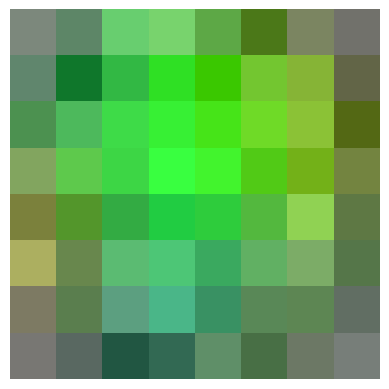

Model accuracy with adversarial patch: 16.40%
Untargeted attack success rate on test set: 83.60%


(0.164, 0.836)

In [35]:
# Generate adversarial patch
patch_untarget_stronger = generate_adversarial_patch(model=resnet18, patch_size=8, target_class=None, num_epochs=10, lr=1e-1, momentum=0.8, apply=apply_extension)
# Visualize the generated patch
visualize_patch(patch_untarget_stronger)
# Test adversarial success rate on test dataset
test(model=resnet18, patch=patch_untarget_stronger, target_class=None, apply=apply_extension)

Epoch 1
Target class: 5
Percentage of samples predicted as target class 5: 7.470000000000001
Accuracy: 0.5679

Epoch 2
Target class: 5
Percentage of samples predicted as target class 5: 52.75
Accuracy: 0.2673

Epoch 3
Target class: 5
Percentage of samples predicted as target class 5: 57.37
Accuracy: 0.2364

Epoch 4
Target class: 5
Percentage of samples predicted as target class 5: 60.78
Accuracy: 0.2238

Epoch 5
Target class: 5
Percentage of samples predicted as target class 5: 60.89
Accuracy: 0.2196

Epoch 6
Target class: 5
Percentage of samples predicted as target class 5: 62.839999999999996
Accuracy: 0.2104

Epoch 7
Target class: 5
Percentage of samples predicted as target class 5: 64.23
Accuracy: 0.2076

Epoch 8
Target class: 5
Percentage of samples predicted as target class 5: 64.55
Accuracy: 0.2049

Epoch 9
Target class: 5
Percentage of samples predicted as target class 5: 64.77000000000001
Accuracy: 0.2026

Epoch 10
Target class: 5
Percentage of samples predicted as target class

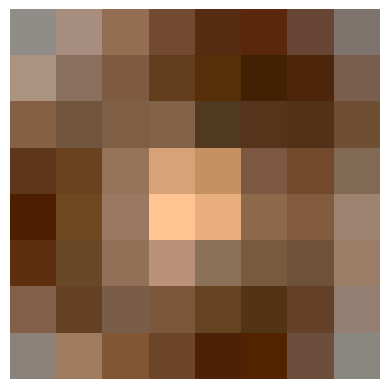

Model accuracy with adversarial patch: 25.66%
Untargeted attack success rate on test set: 74.34%
Targeted attack success rate on test set for class 5: 34.45%


(0.2566, 0.7434, 0.3445)

In [36]:
# Generate adversarial patch
patch_target_stronger = generate_adversarial_patch(model=resnet18, patch_size=8, target_class=5, num_epochs=10, lr=1e-1, momentum=0.8, apply=apply_extension)
# Visualize the generated patch
visualize_patch(patch_target_stronger)
# Test adversarial success rate on test dataset
test(model=resnet18, patch=patch_target_stronger, target_class=5, apply=apply_extension)

In [37]:
# Load pre-trained model
vgg19 = models.vgg19(weights="DEFAULT")

# Get the number of input features to the classifier
num_features = vgg19.classifier[-1].in_features

# Replace the last layer (classifier) for CIFAR-10, which has 10 classes
vgg19.classifier[-1] = nn.Linear(num_features, 10)

# Finetune the model
# fine_tune_for_cifar10(model=vgg19, num_epochs=30, model_path="vgg19.pth")
# Load best model checkpoint
vgg19 = load_model(vgg19, "vgg19.pth", device=device)
# Test model performance on clean test dataset
test(model=vgg19, patch=None, target_class=None, apply=apply_extension)

# Untargeted Attack
test(model=vgg19, patch=patch_untarget_stronger, target_class=None, apply=apply_extension)
# Targeted Attack
test(model=vgg19, patch=patch_target_stronger, target_class=5, apply=apply_extension)

Model accuracy on clean test set: 88.29%
Model accuracy with adversarial patch: 20.59%
Untargeted attack success rate on test set: 79.41%
Model accuracy with adversarial patch: 34.15%
Untargeted attack success rate on test set: 65.85%
Targeted attack success rate on test set for class 5: 22.02%


(0.3415, 0.6585, 0.2202)

In [38]:
# Load pre-trained model
densenet121 = models.densenet121(weights="DEFAULT")

num_features = densenet121.classifier.in_features  # Get the number of input features
densenet121.classifier = nn.Linear(num_features, 10)  # Replace the classifier for CIFAR-10

# Finetune the model
# fine_tune_for_cifar10(model=densenet121, num_epochs=30, model_path="densenet121.pth")
# Load best model checkpoint
densenet121 = load_model(densenet121, "densenet121.pth", device=device)
# Test model performance on clean test dataset
test(model=densenet121, patch=None, target_class=None, apply=apply_extension)

# Untargeted Attack
test(model=densenet121, patch=patch_untarget_stronger, target_class=None, apply=apply_extension)
# Targeted Attack
test(model=densenet121, patch=patch_target_stronger, target_class=5, apply=apply_extension)

Model accuracy on clean test set: 69.56%
Model accuracy with adversarial patch: 24.16%
Untargeted attack success rate on test set: 75.84%
Model accuracy with adversarial patch: 27.75%
Untargeted attack success rate on test set: 72.25%
Targeted attack success rate on test set for class 5: 29.66%


(0.2775, 0.7225, 0.2966)

In [39]:
# Load pre-trained model
resnet50 = models.resnet50(weights="DEFAULT")

# ResNet is trained on ImageNet, which has 1000 classes
# So we need to modify the output layer for CIFAR-10, which has 10 classes
resnet50.fc = nn.Linear(resnet50.fc.in_features, 10)
# Load best model checkpoint
resnet50 = load_model(resnet50, "resnet50.pth", device=device)
# Test model performance on clean test dataset
test(model=resnet50, patch=None, target_class=None, apply=apply_extension)

# Untargeted Attack
test(model=resnet50, patch=patch_untarget_stronger, target_class=None, apply=apply_extension)
# Targeted Attack
test(model=resnet50, patch=patch_target_stronger, target_class=5, apply=apply_extension)

Model accuracy on clean test set: 85.86%
Model accuracy with adversarial patch: 26.05%
Untargeted attack success rate on test set: 73.95%
Model accuracy with adversarial patch: 43.04%
Untargeted attack success rate on test set: 56.96%
Targeted attack success rate on test set for class 5: 11.71%


(0.4304, 0.5696, 0.1171)

In [40]:
# Define the table data
table_data = [
    ["Model", "Untargeted ASR", "Targeted ASR"],
    ["ResNet18", 0.8360, 0.3445],
    ["ResNet50", 0.7395, 0.1171],
    ["DenseNet121", 0.7584, 0.2966],
    ["VGG19", 0.7941, 0.2202]

]

# Print the table
print("With extended data augmentation:")
print(tabulate(table_data, headers="firstrow", tablefmt="grid"))

With extended data augmentation:
+-------------+------------------+----------------+
| Model       |   Untargeted ASR |   Targeted ASR |
+=============+==================+================+
| ResNet18    |           0.836  |         0.3445 |
+-------------+------------------+----------------+
| ResNet50    |           0.7395 |         0.1171 |
+-------------+------------------+----------------+
| DenseNet121 |           0.7584 |         0.2966 |
+-------------+------------------+----------------+
| VGG19       |           0.7941 |         0.2202 |
+-------------+------------------+----------------+


### (Extension) Generate patches with side length of 3,5,7,10,13,16. Visualize patch_sizes v.s. untargeted ASR.

Epoch 1
Target class: None
Accuracy: 0.6276

Epoch 2
Target class: None
Accuracy: 0.4252

Epoch 3
Target class: None
Accuracy: 0.3107

Epoch 4
Target class: None
Accuracy: 0.2466

Epoch 5
Target class: None
Accuracy: 0.2155

Epoch 6
Target class: None
Accuracy: 0.1995

Epoch 7
Target class: None
Accuracy: 0.1837

Epoch 8
Target class: None
Accuracy: 0.1838

Epoch 9
Target class: None
Accuracy: 0.1826

Epoch 10
Target class: None
Accuracy: 0.1828



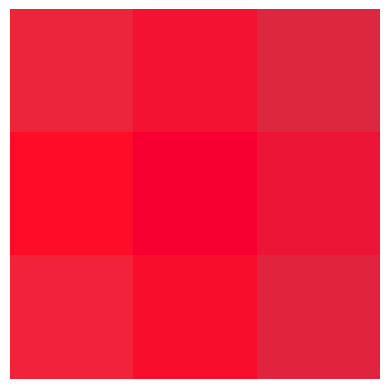

Model accuracy with adversarial patch: 22.30%
Untargeted attack success rate on test set: 77.70%
Epoch 1
Target class: None
Accuracy: 0.5766

Epoch 2
Target class: None
Accuracy: 0.4496

Epoch 3
Target class: None
Accuracy: 0.3476

Epoch 4
Target class: None
Accuracy: 0.262

Epoch 5
Target class: None
Accuracy: 0.2039

Epoch 6
Target class: None
Accuracy: 0.1796

Epoch 7
Target class: None
Accuracy: 0.1646

Epoch 8
Target class: None
Accuracy: 0.1596

Epoch 9
Target class: None
Accuracy: 0.1561

Epoch 10
Target class: None
Accuracy: 0.1554



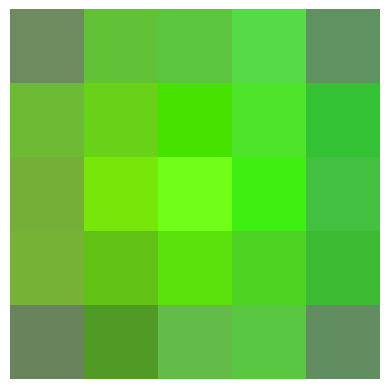

Model accuracy with adversarial patch: 17.99%
Untargeted attack success rate on test set: 82.01%
Epoch 1
Target class: None
Accuracy: 0.5475

Epoch 2
Target class: None
Accuracy: 0.3187

Epoch 3
Target class: None
Accuracy: 0.2212

Epoch 4
Target class: None
Accuracy: 0.195

Epoch 5
Target class: None
Accuracy: 0.1797

Epoch 6
Target class: None
Accuracy: 0.172

Epoch 7
Target class: None
Accuracy: 0.1707

Epoch 8
Target class: None
Accuracy: 0.1678

Epoch 9
Target class: None
Accuracy: 0.1658

Epoch 10
Target class: None
Accuracy: 0.1589



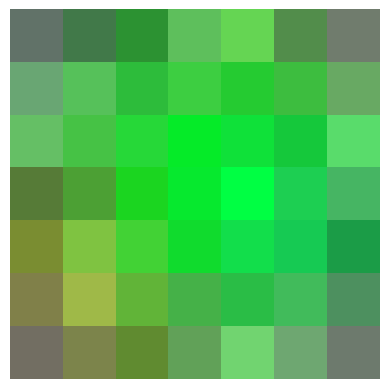

Model accuracy with adversarial patch: 16.87%
Untargeted attack success rate on test set: 83.13%
Epoch 1
Target class: None
Accuracy: 0.4805

Epoch 2
Target class: None
Accuracy: 0.2369

Epoch 3
Target class: None
Accuracy: 0.195

Epoch 4
Target class: None
Accuracy: 0.1811

Epoch 5
Target class: None
Accuracy: 0.1743

Epoch 6
Target class: None
Accuracy: 0.1655

Epoch 7
Target class: None
Accuracy: 0.1656

Epoch 8
Target class: None
Accuracy: 0.158

Epoch 9
Target class: None
Accuracy: 0.1577

Epoch 10
Target class: None
Accuracy: 0.1592



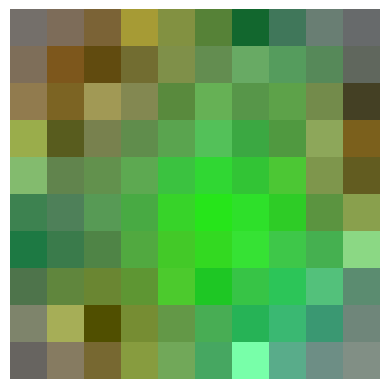

Model accuracy with adversarial patch: 16.44%
Untargeted attack success rate on test set: 83.56%
Epoch 1
Target class: None
Accuracy: 0.4753

Epoch 2
Target class: None
Accuracy: 0.2053

Epoch 3
Target class: None
Accuracy: 0.183

Epoch 4
Target class: None
Accuracy: 0.1796

Epoch 5
Target class: None
Accuracy: 0.181

Epoch 6
Target class: None
Accuracy: 0.1789

Epoch 7
Target class: None
Accuracy: 0.179

Epoch 8
Target class: None
Accuracy: 0.1751

Epoch 9
Target class: None
Accuracy: 0.1725

Epoch 10
Target class: None
Accuracy: 0.1728



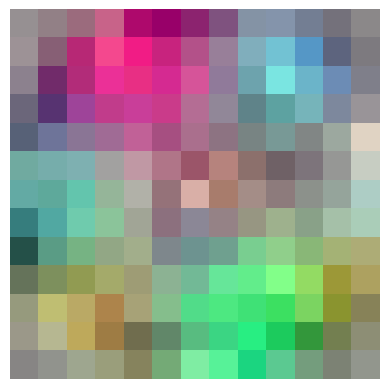

Model accuracy with adversarial patch: 18.30%
Untargeted attack success rate on test set: 81.70%
Epoch 1
Target class: None
Accuracy: 0.3881

Epoch 2
Target class: None
Accuracy: 0.193

Epoch 3
Target class: None
Accuracy: 0.1734

Epoch 4
Target class: None
Accuracy: 0.1687

Epoch 5
Target class: None
Accuracy: 0.1652

Epoch 6
Target class: None
Accuracy: 0.1743

Epoch 7
Target class: None
Accuracy: 0.1681

Epoch 8
Target class: None
Accuracy: 0.1669

Epoch 9
Target class: None
Accuracy: 0.1656

Epoch 10
Target class: None
Accuracy: 0.1659



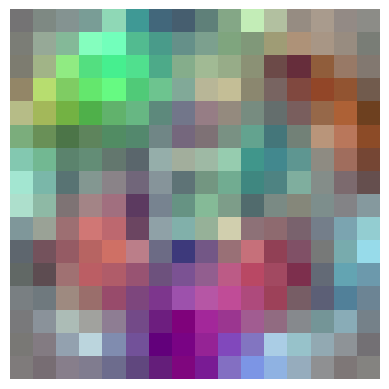

Model accuracy with adversarial patch: 17.05%
Untargeted attack success rate on test set: 82.95%


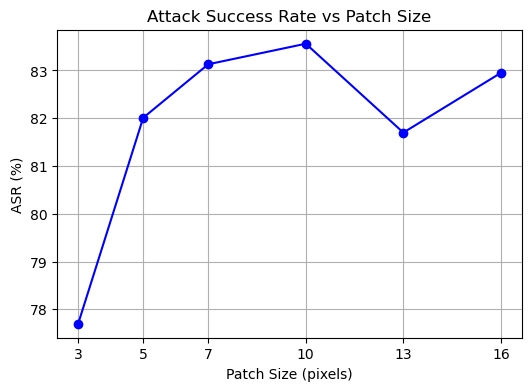

In [43]:
patch_sizes = [3, 5, 7, 10, 13, 16]
untargetted_asr_results = {}
for size in patch_sizes:
  patch = generate_adversarial_patch(model=resnet18, patch_size=size, target_class=None, num_epochs=10,\
                                      lr=1e-1, momentum=0.8, apply=apply_extension)
  visualize_patch(patch)
  adversarial_accuracy, untargetted_asr = test(model=resnet18, patch=patch, target_class=None, apply=apply_extension)
  untargetted_asr_results[size] = untargetted_asr
plot_asr_vs_patch_size(patch_sizes, untargetted_asr_results)

### (Extension) Generate patches with side length of 3,5,7,10,13,16. Visualize patch_sizes v.s. targeted ASR. Target class is set to 5 here.

Epoch 1
Target class: 5
Percentage of samples predicted as target class 5: 8.38
Accuracy: 0.6146

Epoch 2
Target class: 5
Percentage of samples predicted as target class 5: 18.310000000000002
Accuracy: 0.4308

Epoch 3
Target class: 5
Percentage of samples predicted as target class 5: 18.55
Accuracy: 0.3714

Epoch 4
Target class: 5
Percentage of samples predicted as target class 5: 19.24
Accuracy: 0.345

Epoch 5
Target class: 5
Percentage of samples predicted as target class 5: 18.12
Accuracy: 0.3352

Epoch 6
Target class: 5
Percentage of samples predicted as target class 5: 17.36
Accuracy: 0.3413

Epoch 7
Target class: 5
Percentage of samples predicted as target class 5: 18.34
Accuracy: 0.3216

Epoch 8
Target class: 5
Percentage of samples predicted as target class 5: 18.63
Accuracy: 0.3251

Epoch 9
Target class: 5
Percentage of samples predicted as target class 5: 18.13
Accuracy: 0.3189

Epoch 10
Target class: 5
Percentage of samples predicted as target class 5: 18.15
Accuracy: 0.3135

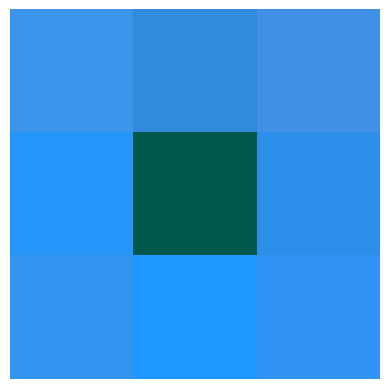

Model accuracy with adversarial patch: 34.39%
Untargeted attack success rate on test set: 65.61%
Targeted attack success rate on test set for class 5: 15.46%
Epoch 1
Target class: 5
Percentage of samples predicted as target class 5: 9.030000000000001
Accuracy: 0.6013

Epoch 2
Target class: 5
Percentage of samples predicted as target class 5: 32.190000000000005
Accuracy: 0.373

Epoch 3
Target class: 5
Percentage of samples predicted as target class 5: 33.660000000000004
Accuracy: 0.3222

Epoch 4
Target class: 5
Percentage of samples predicted as target class 5: 33.93
Accuracy: 0.2948

Epoch 5
Target class: 5
Percentage of samples predicted as target class 5: 33.79
Accuracy: 0.29

Epoch 6
Target class: 5
Percentage of samples predicted as target class 5: 35.55
Accuracy: 0.2854

Epoch 7
Target class: 5
Percentage of samples predicted as target class 5: 34.83
Accuracy: 0.2837

Epoch 8
Target class: 5
Percentage of samples predicted as target class 5: 35.13
Accuracy: 0.2794

Epoch 9
Target 

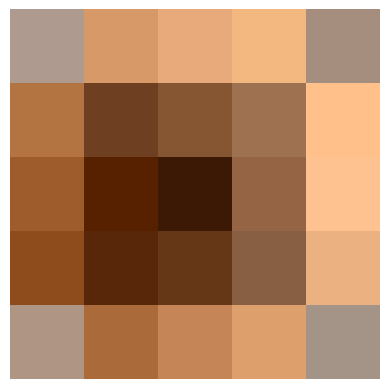

Model accuracy with adversarial patch: 28.71%
Untargeted attack success rate on test set: 71.29%
Targeted attack success rate on test set for class 5: 18.68%
Epoch 1
Target class: 5
Percentage of samples predicted as target class 5: 8.82
Accuracy: 0.5833

Epoch 2
Target class: 5
Percentage of samples predicted as target class 5: 48.17
Accuracy: 0.2904

Epoch 3
Target class: 5
Percentage of samples predicted as target class 5: 55.81
Accuracy: 0.2441

Epoch 4
Target class: 5
Percentage of samples predicted as target class 5: 58.199999999999996
Accuracy: 0.2327

Epoch 5
Target class: 5
Percentage of samples predicted as target class 5: 60.38
Accuracy: 0.2198

Epoch 6
Target class: 5
Percentage of samples predicted as target class 5: 60.83
Accuracy: 0.2187

Epoch 7
Target class: 5
Percentage of samples predicted as target class 5: 61.95
Accuracy: 0.2161

Epoch 8
Target class: 5
Percentage of samples predicted as target class 5: 61.31999999999999
Accuracy: 0.2123

Epoch 9
Target class: 5
Pe

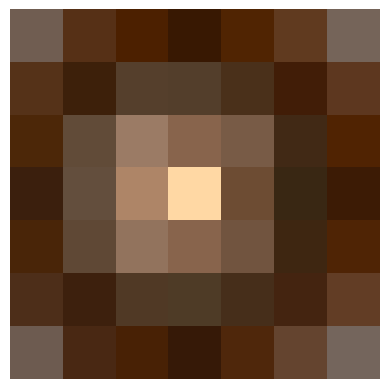

Model accuracy with adversarial patch: 25.29%
Untargeted attack success rate on test set: 74.71%
Targeted attack success rate on test set for class 5: 34.93%
Epoch 1
Target class: 5
Percentage of samples predicted as target class 5: 9.29
Accuracy: 0.5425

Epoch 2
Target class: 5
Percentage of samples predicted as target class 5: 66.74
Accuracy: 0.2183

Epoch 3
Target class: 5
Percentage of samples predicted as target class 5: 70.09
Accuracy: 0.1999

Epoch 4
Target class: 5
Percentage of samples predicted as target class 5: 73.07000000000001
Accuracy: 0.1878

Epoch 5
Target class: 5
Percentage of samples predicted as target class 5: 74.1
Accuracy: 0.1803

Epoch 6
Target class: 5
Percentage of samples predicted as target class 5: 74.06
Accuracy: 0.1791

Epoch 7
Target class: 5
Percentage of samples predicted as target class 5: 73.95
Accuracy: 0.1762

Epoch 8
Target class: 5
Percentage of samples predicted as target class 5: 74.79
Accuracy: 0.1805

Epoch 9
Target class: 5
Percentage of sa

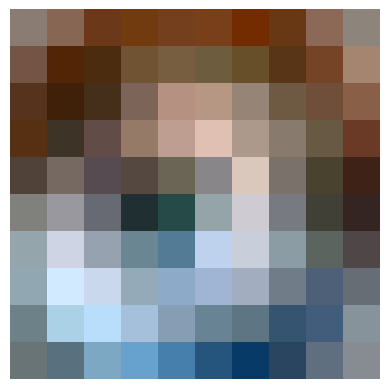

Model accuracy with adversarial patch: 23.50%
Untargeted attack success rate on test set: 76.50%
Targeted attack success rate on test set for class 5: 53.12%
Epoch 1
Target class: 5
Percentage of samples predicted as target class 5: 10.8
Accuracy: 0.5129

Epoch 2
Target class: 5
Percentage of samples predicted as target class 5: 82.28
Accuracy: 0.1769

Epoch 3
Target class: 5
Percentage of samples predicted as target class 5: 84.36
Accuracy: 0.168

Epoch 4
Target class: 5
Percentage of samples predicted as target class 5: 85.14
Accuracy: 0.1623

Epoch 5
Target class: 5
Percentage of samples predicted as target class 5: 85.22
Accuracy: 0.1621

Epoch 6
Target class: 5
Percentage of samples predicted as target class 5: 85.52
Accuracy: 0.1594

Epoch 7
Target class: 5
Percentage of samples predicted as target class 5: 85.89
Accuracy: 0.1594

Epoch 8
Target class: 5
Percentage of samples predicted as target class 5: 86.05000000000001
Accuracy: 0.1574

Epoch 9
Target class: 5
Percentage of sa

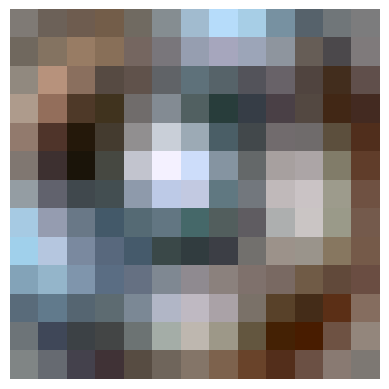

Model accuracy with adversarial patch: 19.02%
Untargeted attack success rate on test set: 80.98%
Targeted attack success rate on test set for class 5: 68.98%
Epoch 1
Target class: 5
Percentage of samples predicted as target class 5: 6.11
Accuracy: 0.3816

Epoch 2
Target class: 5
Percentage of samples predicted as target class 5: 90.59
Accuracy: 0.1377

Epoch 3
Target class: 5
Percentage of samples predicted as target class 5: 91.8
Accuracy: 0.1317

Epoch 4
Target class: 5
Percentage of samples predicted as target class 5: 92.96
Accuracy: 0.1264

Epoch 5
Target class: 5
Percentage of samples predicted as target class 5: 93.25
Accuracy: 0.1235

Epoch 6
Target class: 5
Percentage of samples predicted as target class 5: 93.64
Accuracy: 0.1235

Epoch 7
Target class: 5
Percentage of samples predicted as target class 5: 94.39999999999999
Accuracy: 0.1154

Epoch 8
Target class: 5
Percentage of samples predicted as target class 5: 94.78
Accuracy: 0.1172

Epoch 9
Target class: 5
Percentage of sa

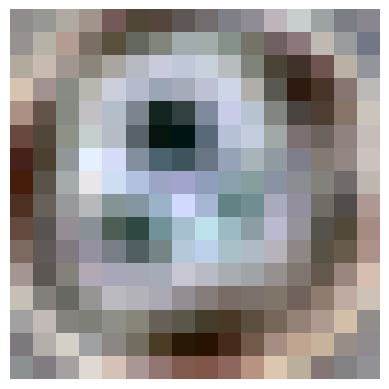

Model accuracy with adversarial patch: 14.01%
Untargeted attack success rate on test set: 85.99%
Targeted attack success rate on test set for class 5: 80.42%


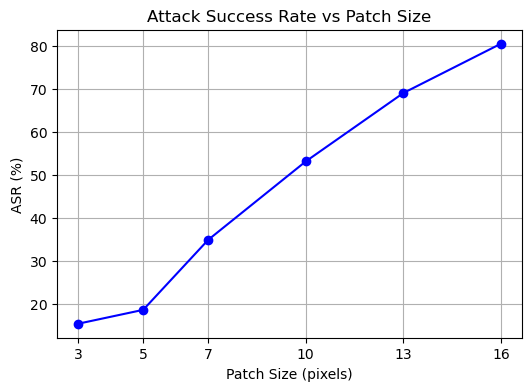

In [44]:
patch_sizes = [3, 5, 7, 10, 13, 16]
targetted_asr_results = {}
for size in patch_sizes:
  patch = generate_adversarial_patch(model=resnet18, patch_size=size, target_class=5, num_epochs=10, \
                                     lr=1e-1, momentum=0.8, apply=apply_extension)
  visualize_patch(patch)
  adversarial_accuracy, untargetted_asr, targetted_asr = test(model=resnet18, patch=patch, target_class=5, apply=apply_extension)
  targetted_asr_results[size] = targetted_asr
plot_asr_vs_patch_size(patch_sizes, targetted_asr_results)